In [47]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import zipfile
import os
import urllib.request
from pgmpy.estimators import HillClimbSearch
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import networkx as nx
import matplotlib.pyplot as plt

# Funciones básicas

**enumerate_seconds**: Genera una lista de strings que representa cada segundo entre dos marcas de tiempo dadas (*start_time* y *end_time*) en formato HH:MM:SS.

**create_bit_vector**: Crea un vector de 0's y 1's en función de si los elementos de *sorted_list* está en *elements*. 

**create_act_number**: Convierte las actividades en SOLO el número de la actividad que corresponde (0 si es Itle). 

**get_activity**: Determina la actividad que se está realizando en un instante de tiempo a partir de un diccionario de actividades con intervalos. Dicho diccionario tiene actividades como claves y su valor es una lista de tuplas (inicio, fin). Lo recorre y si *time* está dentro de algún intervalo, cambia *act* por la actividad correspondiente. 

In [3]:
## First, some methods that I will need
def enumerate_seconds(start_time_str, end_time_str):
    r"""
    Enumerates all seconds in the interval between two timestamps.
    Arguments:
        start_time_str -- Start time in the format 'HH:MM:SS.ssssss'.
        end_time_str -- End time in the format 'HH:MM:SS.ssssss'.
    Returns:
        output -- A list of strings representing each second in the interval, formatted as 'HH:MM:SS'.
    """
    output = []
    # Define the format of the input timestamps
    time_format = "%H:%M:%S.%f"
    
    # Parse the input strings into datetime objects
    start_time = datetime.strptime(start_time_str, time_format)
    end_time = datetime.strptime(end_time_str, time_format)
    
    # Generate all seconds in the interval
    current_time = start_time
    while current_time <= end_time:
        output.append(current_time.strftime("%H:%M:%S"))
        current_time += timedelta(seconds=1)
    return(output)

def create_bit_vector(sorted_list,elements):
    r"""
    Creates a bit vector from a sorted list and a set of elements.
    Arguments:
        sorted_list -- A sorted list of elements.
        elements -- A set of elements to check against the sorted list.
    Returns:
        output -- A list of 1s and 0s, where 1 indicates the element is in the sorted list and 0 indicates it is not.
    """
    output = []
    for i in sorted_list:
        if i in elements:
            output.append(1)
        else:
            output.append(0)
    return output

def create_act_number(act):
    r"""    Converts an activity string to a numerical representation.
    Arguments:
        act -- Activity string, e.g., 'Act24', 'Idle'.
    Returns:
        act -- Numerical representation of the activity, where 'Idle' is 0 and 'ActX' is X.
    """
    if act=="Idle":
        return 0
    else:
        return int(act.replace("Act",""))
    
def getActivity(dic,time):
    r"""
    Given a dictionary of activities with their time intervals and a specific time returns the activity at that time.
    Arguments:
        dic -- Dictionary with activities as keys and lists of one tuple (start_time, end_time) as value.
                {'Act24': [(start_time1, end_time1), (start_time2, end_time2)], ...}
        time -- Time in the format 'HH:MM:SS' to check the activity at that moment.
    Returns:
        act -- The activity at the specified time, or 'Idle' if no activity is found.
    """
    act = "Idle"
    for a in dic:
        for elem in dic[a]:
            if elem[0]<=time and time<=elem[1]:
                act = a
    return act     

Registramos los días del train dentro de **days**.

In [4]:
days = ["2017-10-31","2017-11-02","2017-11-03","2017-11-08","2017-11-10","2017-11-15","2017-11-20"]

---

# Días por separado
## Día 0, A

In [5]:
i,letter = 0,"A" # This is where we can change the day or activity type

# Carga las actividades del día y momento del día especificado en la anterior línea 
activities = pd.read_csv("Data/Training2/%s/%s-%s/%s-%s-activity.csv"%(days[i],days[i],letter,days[i],letter), sep=";")
print("\033[1;32mActivities loaded:\033[0m")
print(activities)
print("\n")

# Crea una lista con todas las horas de inicio (t1) y de fin (t2) del df activities 
t1 = [x.split(" ")[1] for x in activities["DATE BEGIN"].to_list()]
t2 = [x.split(" ")[1] for x in activities["DATE END"].to_list()]

# Crea una lista con SOLO las actividades
acts = activities["ACTIVITY"].to_list()
print("\033[1;34mTimes begin:\033[0m",t1)
print("\033[1;33mTimes end:\033[0m",t2)
print("\033[1;32mActivities:\033[0m",acts)
print("\033[1;35mNumber of activities:\033[0m",len(acts))
print("\n")

# Carga los sensores del día y momento del día especificado 
sensors = pd.read_csv("Data/Training2/%s/%s-%s/%s-%s-sensors.csv"%(days[i],days[i],letter,days[i],letter), sep=";")
print("\033[1;32mSensors loaded:\033[0m")
print(sensors)
print("\033[1;35mNumber of sensors:\033[0m",len(list(set(sensors["OBJECT"].to_list()))))
print("\n")

# Crea una lista con los tiempos del df sensors
timestamps = [x.split(" ")[1] for x in sensors["TIMESTAMP"].to_list()]
# Crea una lista con los sensores del df sensors
objects = sensors["OBJECT"].to_list()
# Crea una lista con los estados del df sensors
states = sensors["STATE"].to_list()

# Crea dic1 para los sensores y dic2 para actividades 
dic1,dic2 = {},{}
for s in set(objects):
    dic1[s] = []
for a in set(acts):
    dic2[a] = []
# A dic1 le asocia como claves los sensores y como valores una lista de tuplas (estado, hora)
for i in range(len(timestamps)):
    dic1[objects[i]].append((states[i],timestamps[i]))
# A dic2 le asocia como claves las actividades y como valores una lista de tuplas (inicio, fin)
for i in range(len(t1)):
    dic2[acts[i]].append((t1[i],t2[i]))

Activities loaded:
              DATE BEGIN               DATE END ACTIVITY HABITANT
0  2017/10/31 11:12:38.0  2017/10/31 11:15:25.0    Act24    Mario
1  2017/10/31 11:15:51.0  2017/10/31 11:16:37.0    Act18    Mario
2  2017/10/31 11:17:04.0  2017/10/31 11:18:06.0    Act16    Mario
3  2017/10/31 11:18:36.0  2017/10/31 11:21:54.0    Act02    Mario
4  2017/10/31 11:22:12.0  2017/10/31 11:24:59.0    Act05    Mario
5  2017/10/31 11:25:55.0  2017/10/31 11:27:06.0    Act17    Mario
6  2017/10/31 11:27:25.0  2017/10/31 11:29:01.0    Act22    Mario
7  2017/10/31 11:29:24.0  2017/10/31 11:30:09.0    Act13    Mario


Times begin: ['11:12:38.0', '11:15:51.0', '11:17:04.0', '11:18:36.0', '11:22:12.0', '11:25:55.0', '11:27:25.0', '11:29:24.0']
Times end: ['11:15:25.0', '11:16:37.0', '11:18:06.0', '11:21:54.0', '11:24:59.0', '11:27:06.0', '11:29:01.0', '11:30:09.0']
Activities: ['Act24', 'Act18', 'Act16', 'Act02', 'Act05', 'Act17', 'Act22', 'Act13']
Number of activities: 8


Sensors loaded:
        

In [6]:
dic1

{'C14': [('Pressure', '11:09:31.0'),
  ('No Pressure', '11:09:32.0'),
  ('Pressure', '11:09:41.0'),
  ('No Pressure', '11:14:59.0'),
  ('Pressure', '11:15:01.0')],
 'D10': [('Open', '11:18:40.0'), ('Close', '11:18:59.0')],
 'C08': [('Open', '11:16:22.0'), ('Close', '11:16:30.0')],
 'D03': [('Open', '11:27:32.0'), ('Close', '11:28:50.0')],
 'C10': [('Open', '11:16:22.0'), ('Close', '11:16:30.0')],
 'SM4': [('Movement', '11:08:55.0'),
  ('No movement', '11:09:11.0'),
  ('Movement', '11:09:31.0'),
  ('No movement', '11:10:06.0'),
  ('Movement', '11:11:21.0'),
  ('No movement', '11:13:40.0'),
  ('Movement', '11:14:58.0'),
  ('No movement', '11:17:04.0'),
  ('Movement', '11:17:22.0'),
  ('No movement', '11:17:42.0'),
  ('Movement', '11:17:43.0'),
  ('No movement', '11:28:15.0'),
  ('Movement', '11:28:16.0'),
  ('No movement', '11:28:31.0'),
  ('Movement', '11:28:41.0'),
  ('No movement', '11:29:36.0'),
  ('Movement', '11:29:37.0'),
  ('No movement', '11:29:46.0')],
 'C12': [('No present', '

Verificamos que en cada sensor hay una longitud par (activación-desactivación)

In [7]:
keys = list(dic1.keys())
all_even = True
for k in keys:
    if len(dic1[k]) % 2 != 0:
        all_even = False
        print(f"\033[1;31mError: Sensor {k} tiene un número impar de lecturas\033[0m")
if all_even:
    print("\033[1;32mTodos los sensores tienen un número par de lecturas\033[0m")

Error: Sensor C14 tiene un número impar de lecturas
Error: Sensor SM3 tiene un número impar de lecturas


In [8]:
dic2

{'Act16': [('11:17:04.0', '11:18:06.0')],
 'Act18': [('11:15:51.0', '11:16:37.0')],
 'Act24': [('11:12:38.0', '11:15:25.0')],
 'Act13': [('11:29:24.0', '11:30:09.0')],
 'Act17': [('11:25:55.0', '11:27:06.0')],
 'Act22': [('11:27:25.0', '11:29:01.0')],
 'Act05': [('11:22:12.0', '11:24:59.0')],
 'Act02': [('11:18:36.0', '11:21:54.0')]}

Notemos que con este diccionario podemos construir un grafo indicando la secuencia de actividades de esa mañana, donde cada nodo indica una actividad y cada nodo tiene un lazo indicando el tiempo de esa actividad y una flecha indicando la siguiente:

In [9]:
# Generamos una lista con las actividades ordenadas por hora de inicio
sorted_acts = sorted(dic2.keys(), key=lambda x: dic2[x][0][0])
print("\033[1;32mSorted activities:\033[0m", sorted_acts)

Sorted activities: ['Act24', 'Act18', 'Act16', 'Act02', 'Act05', 'Act17', 'Act22', 'Act13']


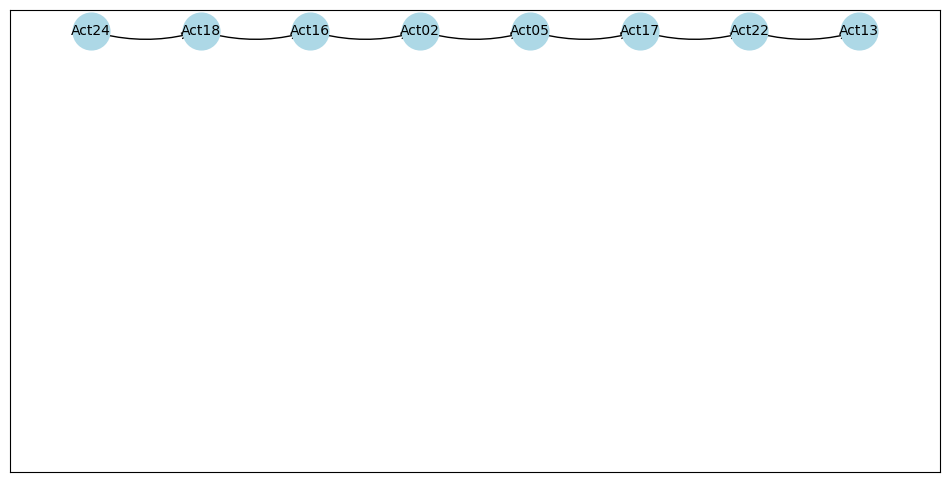

In [10]:
# Generamos un grafo con las actividades y sus tiempos
G = nx.DiGraph()


for i in range(len(sorted_acts)-1):
    G.add_edge(sorted_acts[i], sorted_acts[i+1], weight='')

# Añadimos etiquetas de duración a los nodos
duraciones = {}
for act in sorted_acts:
    start_time = datetime.strptime(dic2[act][0][0], "%H:%M:%S.%f")
    end_time = datetime.strptime(dic2[act][0][1], "%H:%M:%S.%f")
    duration = end_time - start_time
    duration = duration.total_seconds()  # Convertimos a segundos
    duraciones[act] = duration

pos = {sorted_acts[i]: (i, 0) for i in range(len(sorted_acts))}

# Dibujamos el grafo
plt.figure(figsize=(12, 6))
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrows=True, arrowstyle='->', connectionstyle='arc3,rad=0.15')
# Añadimos etiquetas de la duración de actividades a encima de los nodos
plt.show()

Establecemos el intervalo de tiempo en el que vamos a trabajar. Para ello, cogemos el primer segundo entre la primera hora de los datos de tiempo de los sensores *timestamps[0]* y de las actividades *t1[0]*. Hacemos lo mismo para establecer el último segundo del intervalo. 

In [11]:
tbegin,tend = min(timestamps[0],t1[0]),max(timestamps[-1],t2[-1])
print("\033[1;34mTime begin:\033[0m",tbegin)
print("\033[1;33mTime end:\033[0m",tend)

Time begin: 11:08:55.0
Time end: 11:30:09.0


Creamos el diccionario **data** donde las claves son todos los segundos del intervalo definido anteriormente (utiliza la función **enumerate_seconds** para ello) y los valores son las actividades que están ocurriendo en ese segundo (utiliza **getActivity** y **dic2** para ello).

In [12]:
data = {}
for t in enumerate_seconds(tbegin,tend):
    data[t] = [getActivity(dic2,t)]

print("\033[1;32mData created:\033[0m")
data

Data created:


{'11:08:55': ['Idle'],
 '11:08:56': ['Idle'],
 '11:08:57': ['Idle'],
 '11:08:58': ['Idle'],
 '11:08:59': ['Idle'],
 '11:09:00': ['Idle'],
 '11:09:01': ['Idle'],
 '11:09:02': ['Idle'],
 '11:09:03': ['Idle'],
 '11:09:04': ['Idle'],
 '11:09:05': ['Idle'],
 '11:09:06': ['Idle'],
 '11:09:07': ['Idle'],
 '11:09:08': ['Idle'],
 '11:09:09': ['Idle'],
 '11:09:10': ['Idle'],
 '11:09:11': ['Idle'],
 '11:09:12': ['Idle'],
 '11:09:13': ['Idle'],
 '11:09:14': ['Idle'],
 '11:09:15': ['Idle'],
 '11:09:16': ['Idle'],
 '11:09:17': ['Idle'],
 '11:09:18': ['Idle'],
 '11:09:19': ['Idle'],
 '11:09:20': ['Idle'],
 '11:09:21': ['Idle'],
 '11:09:22': ['Idle'],
 '11:09:23': ['Idle'],
 '11:09:24': ['Idle'],
 '11:09:25': ['Idle'],
 '11:09:26': ['Idle'],
 '11:09:27': ['Idle'],
 '11:09:28': ['Idle'],
 '11:09:29': ['Idle'],
 '11:09:30': ['Idle'],
 '11:09:31': ['Idle'],
 '11:09:32': ['Idle'],
 '11:09:33': ['Idle'],
 '11:09:34': ['Idle'],
 '11:09:35': ['Idle'],
 '11:09:36': ['Idle'],
 '11:09:37': ['Idle'],
 '11:09:38'

El valor `Idle` indica que en ese momento no estaba realizando ninguna actividad de las registradas. Aunque parezca que hay un fallo de lectura y únicamente obtenemos este valor, no es así, con el siguiente código podemos ver todas las actividades que ha realizado.

In [13]:
# Revisamos que no todos los valores sean 'Idle'
values = list(data.values())
val = set([])
for i in range(len(values)): 
    for v in values[i]: val.add(v)
print("\033[1;35mUnique values in data:\033[0m",val)

Unique values in data: {'Act16', 'Act18', 'Act24', 'Act13', 'Act17', 'Act22', 'Act05', 'Act02', 'Idle'}


Añadimos los sensores que estuvieron activos en cada segundo como valor del diccionario **data**. 

\* Como hemos eliminado todas las anomalías, siempre habrá pares correctos.

In [14]:
for elem in dic1:
    events = dic1[elem]
    if len(events) > 1:
        for i in range(len(events)//2-1):
            start_time = events[2*i][1]
            end_time = events[2*i + 1][1]
            for t in enumerate_seconds(start_time, end_time):
                if t in data:
                    data[t].append(elem)
data

{'11:08:55': ['Idle', 'SM4'],
 '11:08:56': ['Idle', 'SM4'],
 '11:08:57': ['Idle', 'SM4'],
 '11:08:58': ['Idle', 'SM4'],
 '11:08:59': ['Idle', 'SM4'],
 '11:09:00': ['Idle', 'SM4'],
 '11:09:01': ['Idle', 'SM4'],
 '11:09:02': ['Idle', 'SM4'],
 '11:09:03': ['Idle', 'SM4'],
 '11:09:04': ['Idle', 'SM4'],
 '11:09:05': ['Idle', 'SM4'],
 '11:09:06': ['Idle', 'SM4'],
 '11:09:07': ['Idle', 'SM4'],
 '11:09:08': ['Idle', 'SM4'],
 '11:09:09': ['Idle', 'SM4'],
 '11:09:10': ['Idle', 'SM4'],
 '11:09:11': ['Idle', 'SM4'],
 '11:09:12': ['Idle'],
 '11:09:13': ['Idle'],
 '11:09:14': ['Idle'],
 '11:09:15': ['Idle'],
 '11:09:16': ['Idle'],
 '11:09:17': ['Idle'],
 '11:09:18': ['Idle'],
 '11:09:19': ['Idle'],
 '11:09:20': ['Idle'],
 '11:09:21': ['Idle'],
 '11:09:22': ['Idle'],
 '11:09:23': ['Idle'],
 '11:09:24': ['Idle'],
 '11:09:25': ['Idle'],
 '11:09:26': ['Idle'],
 '11:09:27': ['Idle'],
 '11:09:28': ['Idle'],
 '11:09:29': ['Idle'],
 '11:09:30': ['Idle'],
 '11:09:31': ['Idle', 'C14', 'SM4'],
 '11:09:32': ['I

In [15]:
print(len(data))

1275


Generamos una lista ordenada alfabéticamente **sorted_list_sensors** de los sensores sin duplicados.

In [16]:
sorted_list_of_sensors = sorted(list(set(objects)))
sorted_list_of_sensors

['C08',
 'C09',
 'C10',
 'C12',
 'C14',
 'D01',
 'D02',
 'D03',
 'D07',
 'D10',
 'M01',
 'SM1',
 'SM3',
 'SM4']

Transformamos el diccionario **data** en una estructura tipo tabla (lista de listas) **data_pd** donde cada fila representa un segundo con información codificada en 0's y 1's sobre sensores y actividades. 

\* Recordemos que data[t][0] es el nombre de la actividad y data[t][1:] es la lista de objetos activos en ese segundo

Devuelve un vector binario indicando qué sensores (de la lista ordenada **sorted_list_of_sensors**) están activos ese segundo.

Ejemplo: si sorted_list_of_sensors = ['C08', 'C09', 'C10'] y data[t][1:] = ['C08', 'C09'], el resultado será [1, 1, 0].

In [17]:
data_pd = []
for t in enumerate_seconds(tbegin,tend):
    # Crea una lista binaria + número de actividad
    data_pd.append(create_bit_vector(sorted_list_of_sensors,data[t][1:])+[create_act_number(data[t][0])])
    
data_pd

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [18]:
data_pd[-1]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13]

Creamos un **df** de pandas a través de **data_pd** y asigna nombres a las columnas. En primer lugar, pone el nombre de todos los sensores y luego añade la columna 'Activity'.

In [19]:
df = pd.DataFrame(data_pd, columns=sorted_list_of_sensors+["Activity"])
df

C08  C09  C10  C12  C14  D01  D02  D03  D07  D10  M01  SM1  SM3  SM4  \
0       0    0    0    0    0    0    0    0    0    0    0    0    0    1   
1       0    0    0    0    0    0    0    0    0    0    0    0    0    1   
2       0    0    0    0    0    0    0    0    0    0    0    0    0    1   
3       0    0    0    0    0    0    0    0    0    0    0    0    0    1   
4       0    0    0    0    0    0    0    0    0    0    0    0    0    1   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1270    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1271    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1272    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1273    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1274    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

      Activity  
0            0  
1            0  
2            0  
3            0  
4            0  
...        ...  
1270        13  
1271        13  
1272        13  
1273        13  
1274        13  

[1275 rows x 15 columns]

Esto ha sido para un único día, nos gustaría crear una red Bayesiana que tenga en cuenta todos los sensoseres todas las actividades de la mañana y todos los días posibles para entrenarla. 

### Redes Bayesianas 

#### Modelo

Utilizamos el método de aprendizaje **HillClimbSearch** para estructurar un modelo gráfico bayesiano a partir de los datos de **df**. El objetivo es encontrar la mejor estructura (red de relaciones entre variables) que explique esos datos. 

Para estimar la estructura del modelo usamos **hc.estimate**. Su criterio de optimización será el BIC discreto **bic-d** que penaliza la complejidad para evitar el sobreajuste. 

El modelo aprendido representa dependencias probabilísticas entre sensores y actividad.

Graficamos para visualizarlo.

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D07': 'N', 'D10': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D07': 'N', 'D10': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D07': 'N', 'D10': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}
  0%|          | 9/1000000 [00:00<26:54:46, 10.32it/s] 


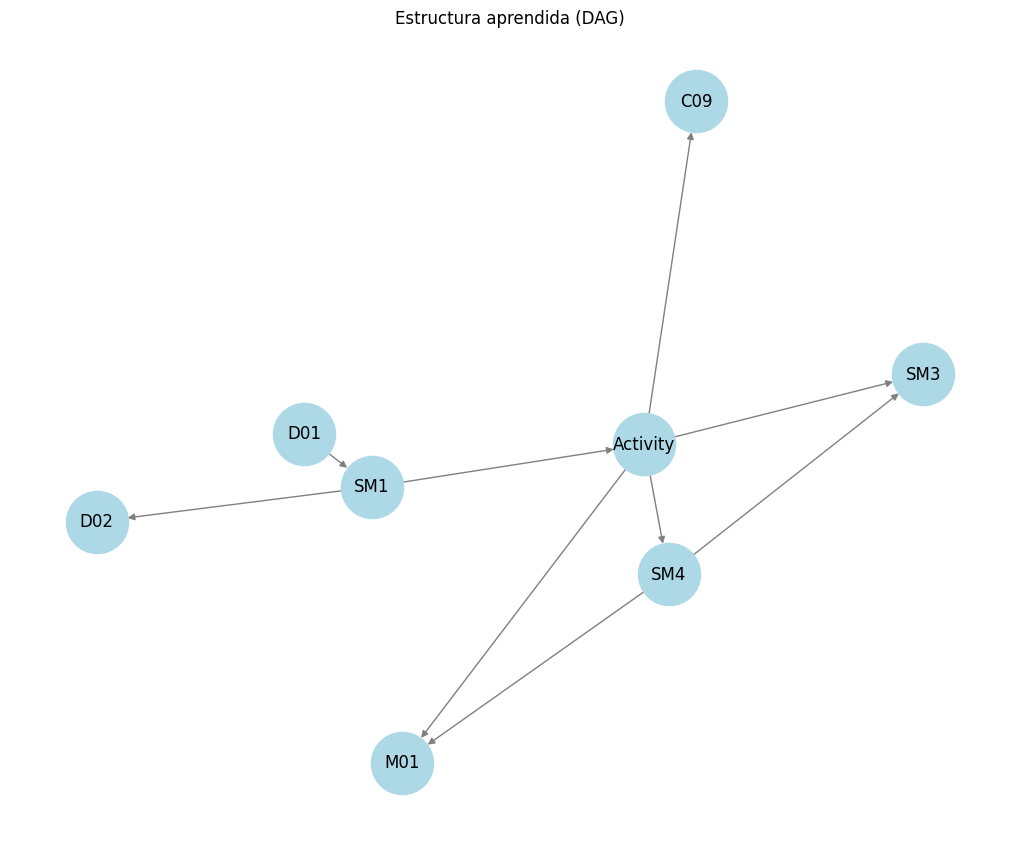

In [20]:
# Aprender la estructura de la red bayesiana
hc = HillClimbSearch(df)
model = hc.estimate(scoring_method="bic-d")

import matplotlib.pyplot as plt
import networkx as nx

# model es un objeto pgmpy.base.DAG
G = nx.DiGraph(model.edges())

plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=12)
plt.title("Estructura aprendida (DAG)")
plt.show()

In [21]:
print("Estructura aprendida:")
print(model.edges())

Estructura aprendida:
[('D01', 'SM1'), ('SM1', 'Activity'), ('SM1', 'D02'), ('SM4', 'M01'), ('SM4', 'SM3'), ('Activity', 'SM3'), ('Activity', 'SM4'), ('Activity', 'C09'), ('Activity', 'M01')]


#### Creación

*model.edges()* devuelve las relaciones dirigidas (aristas) que el HillClimbSearch encontró y *DiscreteBayesianNetwork* crea un objeto red bayesiana con esa estructura, pero aún sin los parámetros (probabilidades).

In [22]:
# Aprender parámetros
bn = DiscreteBayesianNetwork(model.edges())

#### Entrenamiento

Ajusta los parámetros de la red bayesiana usando los datos del DataFrame **df**.

Usa el método de estimación *Máxima Verosimilitud (MLE)* para calcular las probabilidades condicionales de cada nodo dado sus padres en la red.

In [23]:
bn.fit(df, estimator=MaximumLikelihoodEstimator)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D07': 'N', 'D10': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}



Ya tenemos un modelo bayesiano completo, listo para hacer inferencias. Observamos las Tablas de Probabilidad Condicionada.

In [24]:

for cpd in bn.get_cpds():
    print(f"\nCPD de la variable: {cpd.variable}")
    print(cpd)


CPD de la variable: D01
+--------+------------+
| D01(0) | 0.991373   |
+--------+------------+
| D01(1) | 0.00862745 |
+--------+------------+

CPD de la variable: SM1
+--------+---------------------+--------+
| D01    | D01(0)              | D01(1) |
+--------+---------------------+--------+
| SM1(0) | 0.8742088607594937  | 0.0    |
+--------+---------------------+--------+
| SM1(1) | 0.12579113924050633 | 1.0    |
+--------+---------------------+--------+

CPD de la variable: Activity
+--------------+----------------------+---------------------+
| SM1          | SM1(0)               | SM1(1)              |
+--------------+----------------------+---------------------+
| Activity(0)  | 0.38280542986425337  | 0.0                 |
+--------------+----------------------+---------------------+
| Activity(2)  | 0.044343891402714934 | 0.8764705882352941  |
+--------------+----------------------+---------------------+
| Activity(5)  | 0.1321266968325792   | 0.12352941176470589 |
+---------

#### Inferencia Bayesiana

Creamos un motor de inferencia usando el algoritmo de **eliminación de variables**.

In [25]:
# Crear el objeto de inferencia
infer = VariableElimination(bn)
# Definir evidencia: valores discretizados de sensores
evidence = {
    "D02": 1,
    "D07": 0
}

# Crear una copia limpia de la evidencia con solo variables que estén en la red
evidence_clean = {}
for var in evidence:
    if var not in bn.nodes():
        print(f"⚠️ Variable '{var}' no está en la red. No se puede usar como evidencia.")
    else:
        evidence_clean[var] = evidence[var]

# Mostrar la evidencia válida que se usará
print(f"✅ Evidencia utilizada para la inferencia: {evidence_clean}")

# Realizar la inferencia
query_result = infer.query(variables=["Activity"], evidence=evidence_clean)

# Mostrar resultados
print("Distribución de probabilidad para la actividad dada la evidencia:")
print(query_result)

⚠️ Variable 'D07' no está en la red. No se puede usar como evidencia.
✅ Evidencia utilizada para la inferencia: {'D02': 1}
Distribución de probabilidad para la actividad dada la evidencia:
+--------------+-----------------+
| Activity     |   phi(Activity) |
+==============+=================+
| Activity(0)  |          0.0000 |
+--------------+-----------------+
| Activity(2)  |          0.8765 |
+--------------+-----------------+
| Activity(5)  |          0.1235 |
+--------------+-----------------+
| Activity(13) |          0.0000 |
+--------------+-----------------+
| Activity(16) |          0.0000 |
+--------------+-----------------+
| Activity(17) |          0.0000 |
+--------------+-----------------+
| Activity(18) |          0.0000 |
+--------------+-----------------+
| Activity(22) |          0.0000 |
+--------------+-----------------+
| Activity(24) |          0.0000 |
+--------------+-----------------+


## Día 1, A

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C09': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D03': 'N', 'D04': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C09': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D03': 'N', 'D04': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C09': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D03': 'N', 'D04': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}


              DATE BEGIN               DATE END ACTIVITY HABITANT
0  2017/11/02 10:05:08.0  2017/11/02 10:08:07.0    Act24    Mario
1  2017/11/02 10:08:41.0  2017/11/02 10:10:10.0    Act02    Mario
2  2017/11/02 10:10:31.0  2017/11/02 10:14:47.0    Act05    Mario
3  2017/11/02 10:15:04.0  2017/11/02 10:17:02.0    Act17    Mario
4  2017/11/02 10:17:24.0  2017/11/02 10:18:55.0    Act22    Mario
5  2017/11/02 10:19:28.0  2017/11/02 10:20:10.0    Act13    Mario
['10:05:08.0', '10:08:41.0', '10:10:31.0', '10:15:04.0', '10:17:24.0', '10:19:28.0']
['10:08:07.0', '10:10:10.0', '10:14:47.0', '10:17:02.0', '10:18:55.0', '10:20:10.0']
['Act24', 'Act02', 'Act05', 'Act17', 'Act22', 'Act13']
                TIMESTAMP OBJECT        STATE HABITANT
0   2017/11/02 10:05:08.0    C14     Pressure   Mario 
1   2017/11/02 10:05:10.0    C14  No Pressure   Mario 
2   2017/11/02 10:05:26.0    C14     Pressure   Mario 
3   2017/11/02 10:05:29.0    C14  No Pressure   Mario 
4   2017/11/02 10:06:27.0    C14     P

  0%|          | 10/1000000 [00:00<19:47:42, 14.03it/s]


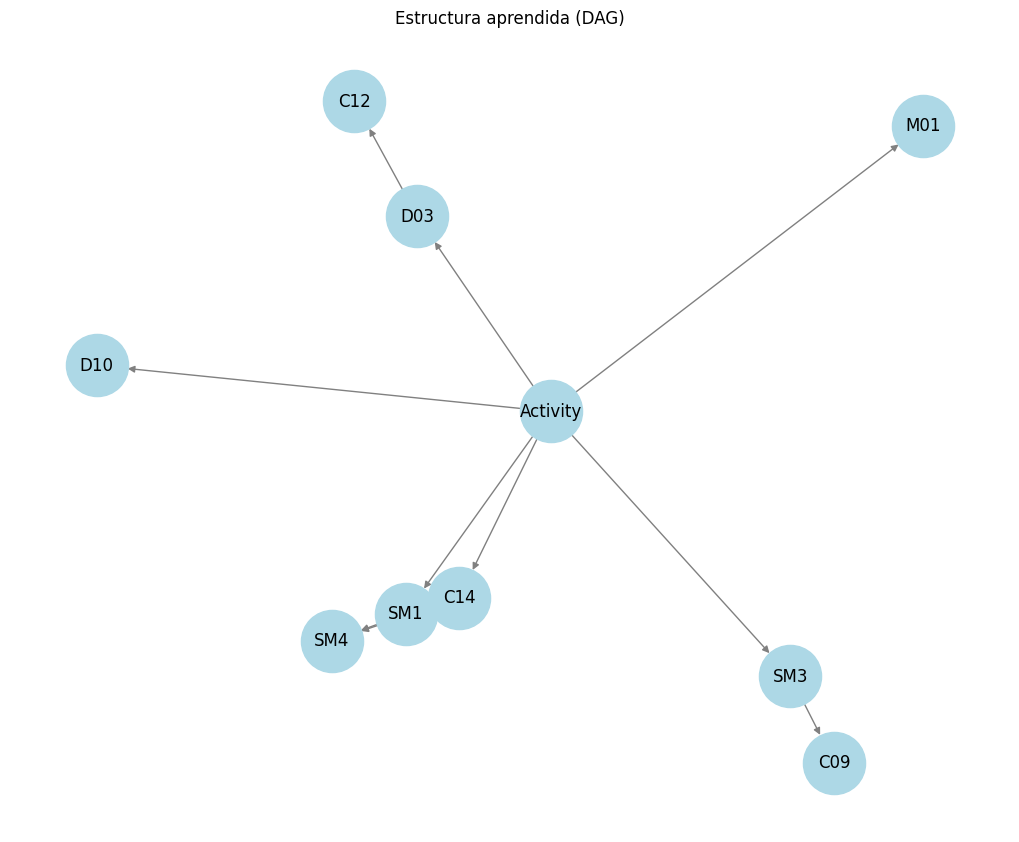

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C09': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D03': 'N', 'D04': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}



CPD de la variable: C14
+----------+-------------+-----+----------------------+
| Activity | Activity(0) | ... | Activity(24)         |
+----------+-------------+-----+----------------------+
| C14(0)   | 0.9921875   | ... | 0.055865921787709494 |
+----------+-------------+-----+----------------------+
| C14(1)   | 0.0078125   | ... | 0.9441340782122905   |
+----------+-------------+-----+----------------------+

CPD de la variable: SM4
+--------+---------------------+--------+--------+--------+
| C14    | C14(0)              | C14(0) | C14(1) | C14(1) |
+--------+---------------------+--------+--------+--------+
| SM1    | SM1(0)              | SM1(1) | SM1(0) | SM1(1) |
+--------+---------------------+--------+--------+--------+
| SM4(0) | 0.09580838323353294 | 0.0    | 1.0    | 0.5    |
+--------+---------------------+--------+--------+--------+
| SM4(1) | 0.9041916167664671  | 1.0    | 0.0    | 0.5    |
+--------+---------------------+--------+--------+--------+

CPD de la variabl

In [26]:
i,letter = 1,"A" # This is where we can change the day or activity type

# Carga las actividades del día y momento del día especificado en la anterior línea 
activities = pd.read_csv("Data/Training2/%s/%s-%s/%s-%s-activity.csv"%(days[i],days[i],letter,days[i],letter), sep=";")
print(activities)

# Crea una lista con todas las horas de inicio (t1) y de fin (t2) del df activities 
t1 = [x.split(" ")[1] for x in activities["DATE BEGIN"].to_list()]
t2 = [x.split(" ")[1] for x in activities["DATE END"].to_list()]

# Crea una lista con SOLO las actividades
acts = activities["ACTIVITY"].to_list()
print(t1)
print(t2)
print(acts)

# Carga los sensores del día y momento del día especificado 
sensors = pd.read_csv("Data/Training2/%s/%s-%s/%s-%s-sensors.csv"%(days[i],days[i],letter,days[i],letter), sep=";")
print(sensors)

# Crea una lista con los tiempos del df sensors
timestamps = [x.split(" ")[1] for x in sensors["TIMESTAMP"].to_list()]
# Crea una lista con los sensores del df sensors
objects = sensors["OBJECT"].to_list()
# Crea una lista con los estados del df sensors
states = sensors["STATE"].to_list()

# Crea dic1 para los sensores y dic2 para actividades 
dic1,dic2 = {},{}
for s in set(objects):
    dic1[s] = []
for a in set(acts):
    dic2[a] = []
# A dic1 le asocia como claves los sensores y como valores una lista de tuplas (estado, hora)
for i in range(len(timestamps)):
    dic1[objects[i]].append((states[i],timestamps[i]))
# A dic2 le asocia como claves las actividades y como valores una lista de tuplas (inicio, fin)
for i in range(len(t1)):
    dic2[acts[i]].append((t1[i],t2[i]))

tbegin,tend = min(timestamps[0],t1[0]),max(timestamps[-1],t2[-1])

data = {}
for t in enumerate_seconds(tbegin,tend):
    data[t] = [getActivity(dic2,t)]

for elem in dic1:
    events = dic1[elem]
    if len(events) > 1:
        for i in range(len(events) - 1):
            start_time = events[i][1]
            end_time = events[i + 1][1]
            for t in enumerate_seconds(start_time, end_time):
                if t in data:
                    data[t].append(elem)

sorted_list_of_sensors = sorted(list(set(objects)))

data_pd = []
for t in enumerate_seconds(tbegin,tend):
    # Crea una lista binaria + número de actividad
    data_pd.append(create_bit_vector(sorted_list_of_sensors,data[t][1:])+[create_act_number(data[t][0])])

df = pd.DataFrame(data_pd, columns=sorted_list_of_sensors+["Activity"])
print(df)

# Aprender la estructura de la red bayesiana
hc = HillClimbSearch(df)
model = hc.estimate(scoring_method="bic-d")

import matplotlib.pyplot as plt
import networkx as nx

# model es un objeto pgmpy.base.DAG
G = nx.DiGraph(model.edges())

plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=12)
plt.title("Estructura aprendida (DAG)")
plt.show()

bn = DiscreteBayesianNetwork(model.edges())

bn.fit(df, estimator=MaximumLikelihoodEstimator)

for cpd in bn.get_cpds():
    print(f"\nCPD de la variable: {cpd.variable}")
    print(cpd)

infer = VariableElimination(bn)
# Definir evidencia: valores discretizados de sensores
evidence = {
    "D03": 1,
    "C12": 0
}

# Crear una copia limpia de la evidencia con solo variables que estén en la red
evidence_clean = {}
for var in evidence:
    if var not in bn.nodes():
        print(f"⚠️ Variable '{var}' no está en la red. No se puede usar como evidencia.")
    else:
        evidence_clean[var] = evidence[var]

# Mostrar la evidencia válida que se usará
print(f"✅ Evidencia utilizada para la inferencia: {evidence_clean}")

# Realizar la inferencia
query_result = infer.query(variables=["Activity"], evidence=evidence_clean)

# Mostrar resultados
print("Distribución de probabilidad para la actividad dada la evidencia:")
print(query_result)

## Día 2, A

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C09': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D10': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C09': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D10': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}


              DATE BEGIN               DATE END ACTIVITY HABITANT
0  2017/11/03 11:47:35.0  2017/11/03 11:50:57.0    Act24    Mario
1  2017/11/03 11:51:18.0  2017/11/03 11:52:14.0    Act16    Mario
2  2017/11/03 11:52:42.0  2017/11/03 11:56:28.0    Act02    Mario
3  2017/11/03 11:56:56.0  2017/11/03 12:00:30.0    Act05    Mario
4  2017/11/03 12:01:18.0  2017/11/03 12:03:23.0    Act17    Mario
5  2017/11/03 12:03:58.0  2017/11/03 12:14:35.0    Act21    Mario
6  2017/11/03 12:14:48.0  2017/11/03 12:15:58.0    Act22    Mario
7  2017/11/03 12:16:38.0  2017/11/03 12:17:16.0    Act13    Mario
['11:47:35.0', '11:51:18.0', '11:52:42.0', '11:56:56.0', '12:01:18.0', '12:03:58.0', '12:14:48.0', '12:16:38.0']
['11:50:57.0', '11:52:14.0', '11:56:28.0', '12:00:30.0', '12:03:23.0', '12:14:35.0', '12:15:58.0', '12:17:16.0']
['Act24', 'Act16', 'Act02', 'Act05', 'Act17', 'Act21', 'Act22', 'Act13']
                TIMESTAMP OBJECT        STATE HABITANT
0   2017/11/03 11:50:46.0    SM4     Movement   Mari

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C09': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D10': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}
  0%|          | 11/1000000 [00:00<14:25:23, 19.26it/s]


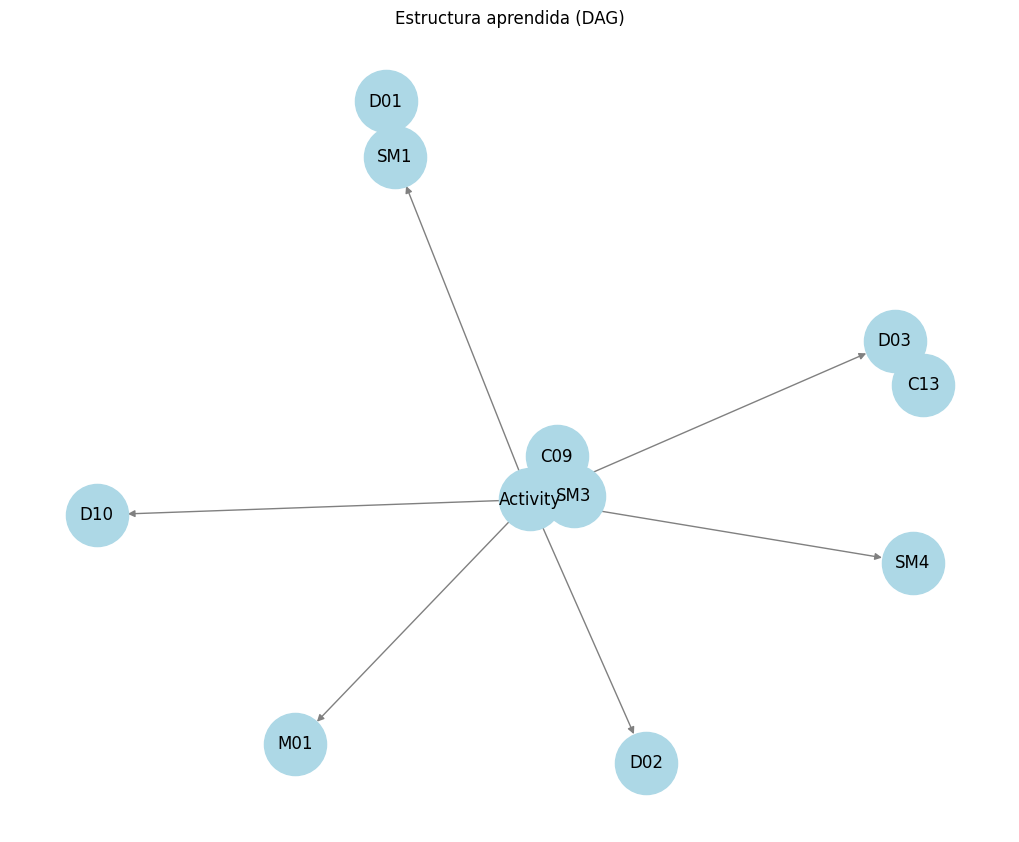

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C09': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D10': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}



CPD de la variable: C09
+--------+---------------------+--------+
| SM3    | SM3(0)              | SM3(1) |
+--------+---------------------+--------+
| C09(0) | 0.9560143626570916  | 0.0    |
+--------+---------------------+--------+
| C09(1) | 0.04398563734290844 | 1.0    |
+--------+---------------------+--------+

CPD de la variable: Activity
+--------------+-----+---------------------+
| C09          | ... | C09(1)              |
+--------------+-----+---------------------+
| SM3          | ... | SM3(1)              |
+--------------+-----+---------------------+
| Activity(0)  | ... | 0.15568862275449102 |
+--------------+-----+---------------------+
| Activity(2)  | ... | 0.3383233532934132  |
+--------------+-----+---------------------+
| Activity(5)  | ... | 0.3203592814371258  |
+--------------+-----+---------------------+
| Activity(13) | ... | 0.0                 |
+--------------+-----+---------------------+
| Activity(16) | ... | 0.03143712574850299 |
+--------------+-----

In [27]:
i,letter = 2,"A" # This is where we can change the day or activity type

# Carga las actividades del día y momento del día especificado en la anterior línea 
activities = pd.read_csv("Data/Training2/%s/%s-%s/%s-%s-activity.csv"%(days[i],days[i],letter,days[i],letter), sep=";")
print(activities)

# Crea una lista con todas las horas de inicio (t1) y de fin (t2) del df activities 
t1 = [x.split(" ")[1] for x in activities["DATE BEGIN"].to_list()]
t2 = [x.split(" ")[1] for x in activities["DATE END"].to_list()]

# Crea una lista con SOLO las actividades
acts = activities["ACTIVITY"].to_list()
print(t1)
print(t2)
print(acts)

# Carga los sensores del día y momento del día especificado 
sensors = pd.read_csv("Data/Training2/%s/%s-%s/%s-%s-sensors.csv"%(days[i],days[i],letter,days[i],letter), sep=";")
print(sensors)

# Crea una lista con los tiempos del df sensors
timestamps = [x.split(" ")[1] for x in sensors["TIMESTAMP"].to_list()]
# Crea una lista con los sensores del df sensors
objects = sensors["OBJECT"].to_list()
# Crea una lista con los estados del df sensors
states = sensors["STATE"].to_list()

# Crea dic1 para los sensores y dic2 para actividades 
dic1,dic2 = {},{}
for s in set(objects):
    dic1[s] = []
for a in set(acts):
    dic2[a] = []
# A dic1 le asocia como claves los sensores y como valores una lista de tuplas (estado, hora)
for i in range(len(timestamps)):
    dic1[objects[i]].append((states[i],timestamps[i]))
# A dic2 le asocia como claves las actividades y como valores una lista de tuplas (inicio, fin)
for i in range(len(t1)):
    dic2[acts[i]].append((t1[i],t2[i]))

tbegin,tend = min(timestamps[0],t1[0]),max(timestamps[-1],t2[-1])

data = {}
for t in enumerate_seconds(tbegin,tend):
    data[t] = [getActivity(dic2,t)]

for elem in dic1:
    events = dic1[elem]
    if len(events) > 1:
        for i in range(len(events) - 1):
            start_time = events[i][1]
            end_time = events[i + 1][1]
            for t in enumerate_seconds(start_time, end_time):
                if t in data:
                    data[t].append(elem)

sorted_list_of_sensors = sorted(list(set(objects)))

data_pd = []
for t in enumerate_seconds(tbegin,tend):
    # Crea una lista binaria + número de actividad
    data_pd.append(create_bit_vector(sorted_list_of_sensors,data[t][1:])+[create_act_number(data[t][0])])

df = pd.DataFrame(data_pd, columns=sorted_list_of_sensors+["Activity"])
print(df)

# Aprender la estructura de la red bayesiana
hc = HillClimbSearch(df)
model = hc.estimate(scoring_method="bic-d")

import matplotlib.pyplot as plt
import networkx as nx

# model es un objeto pgmpy.base.DAG
G = nx.DiGraph(model.edges())

plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=12)
plt.title("Estructura aprendida (DAG)")
plt.show()

bn = DiscreteBayesianNetwork(model.edges())

bn.fit(df, estimator=MaximumLikelihoodEstimator)

for cpd in bn.get_cpds():
    print(f"\nCPD de la variable: {cpd.variable}")
    print(cpd)

infer = VariableElimination(bn)
# Definir evidencia: valores discretizados de sensores
evidence = {
    "D03": 1,
    "C12": 0
}

# Crear una copia limpia de la evidencia con solo variables que estén en la red
evidence_clean = {}
for var in evidence:
    if var not in bn.nodes():
        print(f"⚠️ Variable '{var}' no está en la red. No se puede usar como evidencia.")
    else:
        evidence_clean[var] = evidence[var]

# Mostrar la evidencia válida que se usará
print(f"✅ Evidencia utilizada para la inferencia: {evidence_clean}")

# Realizar la inferencia
query_result = infer.query(variables=["Activity"], evidence=evidence_clean)

# Mostrar resultados
print("Distribución de probabilidad para la actividad dada la evidencia:")
print(query_result)

**CONCLUSIÓN:** Observamos que según el día, la red se forma con unos sensores u otros por tanto al hacer inferencia puede dar errores si se consideran sensores que no están presentes ya que no existen en nuestro modelo. Esto es normal pues la red se entrena con los datos que le pasamos y puede suceder y, de hecho, sucede, que no todos los sensores se activen todos los días.

Para intentar solucionar este problema, vamos a entrenar la red con un único df que cuente con la información de todos los días unidos en vez de separados.


# Todos los días momento A

In [28]:
letter = "A"
all_activities = []
all_sensors = []

for day in days:
    try:
        act_path = f"Data/Training2/{day}/{day}-{letter}/{day}-{letter}-activity.csv"
        sen_path = f"Data/Training2/{day}/{day}-{letter}/{day}-{letter}-sensors.csv"

        df_act = pd.read_csv(act_path, sep=";")
        df_sen = pd.read_csv(sen_path, sep=";")

        # Añadimos columna de día por si quieres rastrear luego
        df_act["DAY"] = day
        df_sen["DAY"] = day

        all_activities.append(df_act)
        all_sensors.append(df_sen)
    except FileNotFoundError:
        print(f"Archivos no encontrados para el día {day} - {letter}. Saltando.")
        continue

# Unimos todos los archivos en dos DataFrames completos
activities = pd.concat(all_activities, ignore_index=True)
sensors = pd.concat(all_sensors, ignore_index=True)

# Crea una lista con todas las horas de inicio (t1) y de fin (t2) del df activities 
t1 = [x.split(" ")[1] for x in activities["DATE BEGIN"].to_list()]
t2 = [x.split(" ")[1] for x in activities["DATE END"].to_list()]

# Crea una lista con SOLO las actividades
acts = activities["ACTIVITY"].to_list()
print(t1)
print(t2)
print(acts)

# Crea una lista con los tiempos del df sensors
timestamps = [x.split(" ")[1] for x in sensors["TIMESTAMP"].to_list()]
# Crea una lista con los sensores del df sensors
objects = sensors["OBJECT"].to_list()
# Crea una lista con los estados del df sensors
states = sensors["STATE"].to_list()

# Crea dic1 para los sensores y dic2 para actividades 
dic1,dic2 = {},{}
for s in set(objects):
    dic1[s] = []
for a in set(acts):
    dic2[a] = []
# A dic1 le asocia como claves los sensores y como valores una lista de tuplas (estado, hora)
for i in range(len(timestamps)):
    dic1[objects[i]].append((states[i],timestamps[i]))
# A dic2 le asocia como claves las actividades y como valores una lista de tuplas (inicio, fin)
for i in range(len(t1)):
    dic2[acts[i]].append((t1[i],t2[i]))

print(dic1) 
print(dic2)

tbegin,tend = min(timestamps[0],t1[0]),max(timestamps[-1],t2[-1])

data = {}
for t in enumerate_seconds(tbegin,tend):
    data[t] = [getActivity(dic2,t)]

for elem in dic1:
    events = dic1[elem]
    if len(events) > 1:
        for i in range(len(events) - 1):
            start_time = events[i][1]
            end_time = events[i + 1][1]
            for t in enumerate_seconds(start_time, end_time):
                if t in data:
                    data[t].append(elem)
print(data)

sorted_list_of_sensors = sorted(list(set(objects)))
print(sorted_list_of_sensors)

data_pd = []
for t in enumerate_seconds(tbegin,tend):
    # Crea una lista binaria + número de actividad
    data_pd.append(create_bit_vector(sorted_list_of_sensors,data[t][1:])+[create_act_number(data[t][0])])
    
print(data_pd)
df = pd.DataFrame(data_pd, columns=sorted_list_of_sensors+["Activity"])
print(df)

['11:12:38.0', '11:15:51.0', '11:17:04.0', '11:18:36.0', '11:22:12.0', '11:25:55.0', '11:27:25.0', '11:29:24.0', '10:05:08.0', '10:08:41.0', '10:10:31.0', '10:15:04.0', '10:17:24.0', '10:19:28.0', '11:47:35.0', '11:51:18.0', '11:52:42.0', '11:56:56.0', '12:01:18.0', '12:03:58.0', '12:14:48.0', '12:16:38.0', '11:59:43.0', '12:01:23.0', '12:02:53.0', '12:05:49.0', '12:10:03.0', '12:11:25.0', '12:12:40.0', '12:14:09.0', '12:26:45.0', '12:29:03.0', '12:30:07.0', '12:31:29.0', '12:34:02.0', '12:39:08.0', '12:40:48.0', '12:43:02.0', '12:24:14.0', '12:25:34.0', '12:26:47.0', '12:27:46.0', '12:32:00.0', '12:36:29.0', '12:38:06.0', '12:40:07.0', '12:09:39.0', '12:11:17.0', '12:12:34.0', '12:14:03.0', '12:20:58.0', '12:27:24.0', '12:28:52.0', '12:31:09.0']
['11:15:25.0', '11:16:37.0', '11:18:06.0', '11:21:54.0', '11:24:59.0', '11:27:06.0', '11:29:01.0', '11:30:09.0', '10:08:07.0', '10:10:10.0', '10:14:47.0', '10:17:02.0', '10:18:55.0', '10:20:10.0', '11:50:57.0', '11:52:14.0', '11:56:28.0', '12:

Ahora, vamos a dividir el conjunto de datos **df** en **df_trainval**, **df_test_simulado** y **df_val**.

In [29]:
from sklearn.model_selection import train_test_split

# Suponemos que 'df_full' es tu conjunto con Activity
# random_state = 42 fija una semilla para la reproducibilidad
# stratify=df['Activity'] asegura que la proporción de clases se mantenga en los conjuntos de entrenamiento y prueba
df_trainval, df_test_simulado = train_test_split(df, test_size=0.15, random_state=42, stratify=df['Activity'])

# Dividimos ahora trainval en train y validación
df_train, df_val = train_test_split(df, test_size=0.18, random_state=42, stratify=df['Activity'])

Veamos que variables toman un ÚNICO valor ya que seguramente estas variables no sean incluídas posteriormente en la red bayesiana por no aportar información.

In [30]:
# Encuentra columnas con un único valor
cols_unico_valor = [col for col in df.columns if df[col].nunique() == 1]

# Mostrar resultados
print("📌 Variables con un único valor en todo el DataFrame:")
for col in cols_unico_valor:
    print(f" - {col}: {df[col].unique()[0]}")


📌 Variables con un único valor en todo el DataFrame:
 - C04: 0
 - C07: 0
 - C09: 1
 - C13: 1
 - D03: 1
 - D04: 1
 - D10: 1
 - H01: 0
 - M01: 1
 - SM1: 1
 - SM3: 1
 - SM4: 1


## Redes Bayesianas

### Modelo

Utilizamos el método de aprendizaje **HillClimbSearch** para estructurar un modelo gráfico bayesiano a partir de los datos de **df**. El objetivo es encontrar la mejor estructura (red de relaciones entre variables) que explique esos datos. 

Para estimar la estructura del modelo usamos **hc.estimate**. Su criterio de optimización será el BIC discreto **bic-d** que penaliza la complejidad para evitar el sobreajuste. 

In [31]:
# Aprender la estructura de la red bayesiana
hc = HillClimbSearch(df_train)
model = hc.estimate(scoring_method="bic-d")

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C04': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D07': 'N', 'D09': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C04': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D07': 'N', 'D09': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C04': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D07': 'N', 'D09': 'N', 

El modelo aprendido representa dependencias probabilísticas entre sensores y actividad.

Graficamos para visualizarlo.

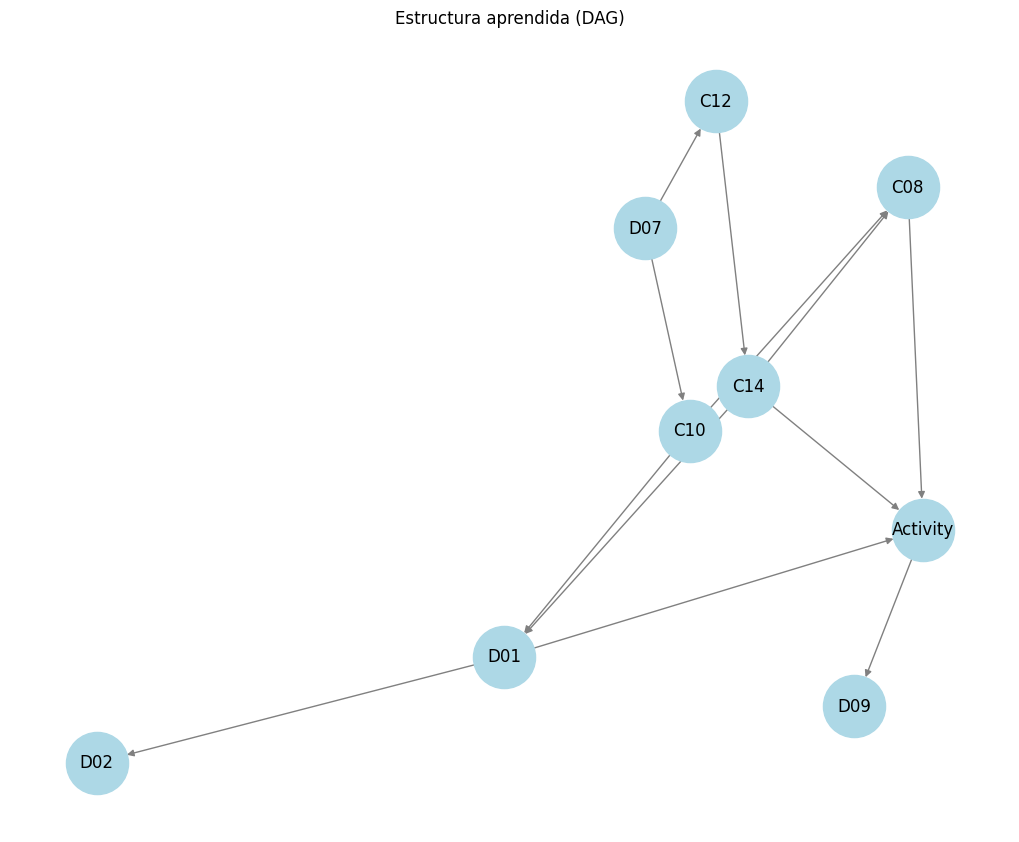

In [32]:
import matplotlib.pyplot as plt
import networkx as nx

# model es un objeto pgmpy.base.DAG
G = nx.DiGraph(model.edges())

plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=12)
plt.title("Estructura aprendida (DAG)")
plt.show()


In [33]:
# Mostrar estructura aprendida
print("Estructura aprendida:")
print(model.edges())

Estructura aprendida:
[('C08', 'Activity'), ('C10', 'C08'), ('C10', 'D01'), ('C12', 'C14'), ('C14', 'D01'), ('C14', 'C08'), ('C14', 'Activity'), ('D01', 'D02'), ('D01', 'Activity'), ('D07', 'C10'), ('D07', 'C12'), ('Activity', 'D09')]


### Creación

*model.edges()* devuelve las relaciones dirigidas (aristas) que el HillClimbSearch encontró y *DiscreteBayesianNetwork* crea un objeto red bayesiana con esa estructura, pero aún sin los parámetros (probabilidades).

In [34]:
# Aprender parámetros
bn = DiscreteBayesianNetwork(model.edges())

### Entrenamiento

Ajusta los parámetros de la red bayesiana usando los datos del DataFrame **df**.

Usa el método de estimación *Máxima Verosimilitud (MLE)* para calcular las probabilidades condicionales de cada nodo dado sus padres en la red.

In [35]:
bn.fit(df_train, estimator=MaximumLikelihoodEstimator)
infer = VariableElimination(bn)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C04': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D07': 'N', 'D09': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}


Veamos que, como mencionamos antes, los nodos que solo toman un valor son justamente aquellos que no forman parte de la red.

In [36]:
print("Nodos del modelo:", model.nodes())
print(len(model.nodes()))
# Encuentra columnas con un único valor
cols_unico_valor = [col for col in df.columns if df[col].nunique() == 1]
# Mostrar resultados
print("📌 Variables con un único valor en todo el DataFrame:")
for col in cols_unico_valor:
    print(f" - {col}: {df[col].unique()[0]}")
print(len(cols_unico_valor))

print("Nodos de la red:", bn.nodes())
print(len(bn.nodes()))

Nodos del modelo: ['C04', 'C07', 'C08', 'C09', 'C10', 'C12', 'C13', 'C14', 'D01', 'D02', 'D03', 'D04', 'D07', 'D09', 'D10', 'H01', 'M01', 'SM1', 'SM3', 'SM4', 'Activity']
21
📌 Variables con un único valor en todo el DataFrame:
 - C04: 0
 - C07: 0
 - C09: 1
 - C13: 1
 - D03: 1
 - D04: 1
 - D10: 1
 - H01: 0
 - M01: 1
 - SM1: 1
 - SM3: 1
 - SM4: 1
12
Nodos de la red: ['C08', 'Activity', 'C10', 'D01', 'C12', 'C14', 'D02', 'D07', 'D09']
9


Observamos las Tablas de Probabilidad Condicionada.

In [37]:
# Mostrar CPTs
for cpd in bn.get_cpds():
    print(f"\nCPD de la variable: {cpd.variable}")
    print(cpd)


CPD de la variable: C08
+--------+--------+--------+--------+---------------------+
| C10    | C10(0) | C10(0) | C10(1) | C10(1)              |
+--------+--------+--------+--------+---------------------+
| C14    | C14(0) | C14(1) | C14(0) | C14(1)              |
+--------+--------+--------+--------+---------------------+
| C08(0) | 1.0    | 1.0    | 1.0    | 0.08387278356318605 |
+--------+--------+--------+--------+---------------------+
| C08(1) | 0.0    | 0.0    | 0.0    | 0.9161272164368139  |
+--------+--------+--------+--------+---------------------+

CPD de la variable: Activity
+--------------+-----+---------------------+---------+
| C08          | ... | C08(1)              | C08(1)  |
+--------------+-----+---------------------+---------+
| C14          | ... | C14(1)              | C14(1)  |
+--------------+-----+---------------------+---------+
| D01          | ... | D01(0)              | D01(1)  |
+--------------+-----+---------------------+---------+
| Activity(0)  | ...

### Evaluación 

In [38]:
model_vars = list(bn.nodes())  # Variables que el modelo sí conoce
model_vars.remove('Activity')  # Queremos predecir esta
print(model_vars)
correct = 0
for _, row in df_val.iterrows():
    # Filtrar solo columnas que están en el modelo
    evidence = row[model_vars].to_dict()
    print(f"Realizando inferencia con evidencia: {evidence}")
    prediction = infer.map_query(['Activity'], evidence=evidence)
    if prediction['Activity'] == row['Activity']:
        correct += 1

accuracy = correct / len(df_val)


['C08', 'C10', 'D01', 'C12', 'C14', 'D02', 'D07', 'D09']
Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}



Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 0, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}



Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 1}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}



Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}



Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 1}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 1}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 0, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}



Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}



Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}



Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 0, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 1}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}



Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}



Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}



Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}



Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 0, 'D02': 1, 'D07': 1, 'D09': 0}

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}



Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}



Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}



Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 1}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 1}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 0, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 0, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}



Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}



Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 1}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 0, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}



Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 1}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}



Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}



Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 1, 'C12': 0, 'C14': 0, 'D02': 1, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 0, 'D01': 0, 'C12': 1, 'C14': 1, 'D02': 0, 'D07': 0, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 0, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Realizando inferencia con evidencia: {'C08': 1, 'C10': 1, 'D01': 1, 'C12': 1, 'C14': 1, 'D02': 1, 'D07': 1, 'D09': 0}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [39]:
print(bn.nodes())

['C08', 'Activity', 'C10', 'D01', 'C12', 'C14', 'D02', 'D07', 'D09']


In [40]:
print(f"Accuracy en validación: {accuracy:.2%}")

Accuracy en validación: 43.70%


Obtenemos una precisión muy baja, vamos a probar a cambiar algunos parámetros.

**HIPERPARÁMETROS**:

* scoring_method	Función de puntuación: BicScore, K2Score, BDeuScore, etc.

* max_indegree	Número máximo de padres que puede tener cada nodo. Ayuda a evitar overfitting.

* max_iter	Número máximo de iteraciones de la búsqueda. Por defecto es infinito. Puedes limitarlo para acotar tiempo.

* tabu_length	Si quieres evitar ciclos durante la búsqueda (por ahora puedes dejarlo en 0).

In [41]:
# Aprender la estructura de la red bayesiana
hc = HillClimbSearch(df_train)
model = hc.estimate(scoring_method="bic-d", max_indegree=2, max_iter=1000, tabu_length=0)
bn = DiscreteBayesianNetwork(model.edges())
bn.fit(df_train, estimator=MaximumLikelihoodEstimator)
model_vars = list(bn.nodes())  # Variables que el modelo sí conoce
model_vars.remove('Activity')  # Queremos predecir esta

correct = 0
for _, row in df_val.iterrows():
    # Filtrar solo columnas que están en el modelo
    evidence = row[model_vars].to_dict()
    prediction = infer.map_query(['Activity'], evidence=evidence)
    if prediction['Activity'] == row['Activity']:
        correct += 1

accuracy = correct / len(df_val)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C04': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D07': 'N', 'D09': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C04': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D07': 'N', 'D09': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C04': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D07': 'N', 'D09': 'N', 

In [42]:
print(f"Accuracy en validación: {accuracy:.2%}")

Accuracy en validación: 43.70%


### Inferencia Bayesiana

Creamos un motor de inferencia usando el algoritmo de **eliminación de variables**. También, añadimos un filtro para que no intente tomar como evidencias aquellas variables que no están en la red.

In [43]:
# Crear el objeto de inferencia
infer = VariableElimination(bn)
# Definir evidencia: valores discretizados de sensores
evidence = {
    "D03": 1,
    "D02": 1,
    "D07": 0
}

evidence_clean = {}
for var in evidence:
    if var not in bn.nodes():
        print(f"⚠️ Variable '{var}' no está en la red. No se puede usar como evidencia.")
    else:
        evidence_clean[var] = evidence[var]

# Mostrar la evidencia válida que se usará
print(f"✅ Evidencia utilizada para la inferencia: {evidence_clean}")

# Realizar la inferencia
query_result = infer.query(variables=["Activity"], evidence=evidence_clean)

# Mostrar resultados
print("Distribución de probabilidad para la actividad dada la evidencia:")
print(query_result)

⚠️ Variable 'D03' no está en la red. No se puede usar como evidencia.
✅ Evidencia utilizada para la inferencia: {'D02': 1, 'D07': 0}
Distribución de probabilidad para la actividad dada la evidencia:
+--------------+-----------------+
| Activity     |   phi(Activity) |
+==============+=================+
| Activity(0)  |          0.0078 |
+--------------+-----------------+
| Activity(2)  |          0.4136 |
+--------------+-----------------+
| Activity(5)  |          0.4904 |
+--------------+-----------------+
| Activity(13) |          0.0239 |
+--------------+-----------------+
| Activity(16) |          0.0003 |
+--------------+-----------------+
| Activity(17) |          0.0439 |
+--------------+-----------------+
| Activity(18) |          0.0000 |
+--------------+-----------------+
| Activity(20) |          0.0004 |
+--------------+-----------------+
| Activity(21) |          0.0028 |
+--------------+-----------------+
| Activity(22) |          0.0006 |
+--------------+---------------

Vamos a forzar que todos los sensores estén presentes en la red **bn2** aunque no tengan conexiones. 

In [44]:
# Asegura que todos los nodos estén en la red, aunque sin conexiones
all_vars = sorted_list_of_sensors + ["Activity"]

# Crear la red e incluir todos los nodos
bn2 = DiscreteBayesianNetwork()
bn2.add_nodes_from(all_vars)

# Añadir las aristas aprendidas por el algoritmo
bn2.add_edges_from(model.edges())

# Ajustar los parámetros (probabilidades) a partir del dataframe
bn2.fit(df, estimator=MaximumLikelihoodEstimator)
print("Nodos del modelo:", model.nodes())
print("Nodos de la red:", bn2.nodes())

# Mostrar las CPDs
for cpd in bn2.get_cpds():               
    print(f"\nCPD de la variable: {cpd.variable}")
    print(cpd)          

# Crear el objeto de inferencia
infer = VariableElimination(bn2)
# Definir evidencia: valores discretizados de sensores
evidence = {
    "D03": 1,
    "D02": 1,
    "D07": 0
}
# Consultar la distribución de probabilidad de la actividad
query_result = infer.query(variables=["Activity"], evidence=evidence)

# Mostrar resultados
print("Distribución de probabilidad para la actividad dada la evidencia:")
print(query_result)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C04': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D07': 'N', 'D09': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}


Nodos del modelo: ['C04', 'C07', 'C08', 'C09', 'C10', 'C12', 'C13', 'C14', 'D01', 'D02', 'D03', 'D04', 'D07', 'D09', 'D10', 'H01', 'M01', 'SM1', 'SM3', 'SM4', 'Activity']
Nodos de la red: ['C04', 'C07', 'C08', 'C09', 'C10', 'C12', 'C13', 'C14', 'D01', 'D02', 'D03', 'D04', 'D07', 'D09', 'D10', 'H01', 'M01', 'SM1', 'SM3', 'SM4', 'Activity']

CPD de la variable: C04
+--------+---+
| C04(0) | 1 |
+--------+---+

CPD de la variable: C07
+--------+---+
| C07(0) | 1 |
+--------+---+

CPD de la variable: C08
+--------+--------+--------+--------+---------------------+
| C10    | C10(0) | C10(0) | C10(1) | C10(1)              |
+--------+--------+--------+--------+---------------------+
| C14    | C14(0) | C14(1) | C14(0) | C14(1)              |
+--------+--------+--------+--------+---------------------+
| C08(0) | 1.0    | 1.0    | 1.0    | 0.08592490209629118 |
+--------+--------+--------+--------+---------------------+
| C08(1) | 0.0    | 0.0    | 0.0    | 0.9140750979037088  |
+--------+----

**CONCLUSIÓN:** De nuevo, si una variable es independiente del resto en los datos observados (por ejemplo, si toma el mismo valor siempre o no aporta información útil para predecir otras) entonces el algoritmo de aprendizaje de la estructura no le asigna ninguna relación en la red y no aparece en el grafo. Así, estas variables no pueden usarse como evidencias de la inferencia. Si forzamos que estén esas variables, debemos asegurarnos que usamos como evidencia el único valor que se le asigna.

# Datos 2

Seguiremos el ejercicio considerando todo el conjunto de datos a la vez en lugar de ir día por día y sin forzar que estén todos los nodos en la red bayesiana.

A continuación el objetivo es plantear dos modelos, uno es el que ya hemos creado donde cada fila es un segundo. El segundo modelo que debemos generar es aquel que toma un df en el que se eliminan las filas que se repiten, es decir, solo indica si una secuencia se realiza o no, en vez de indicar también todas las veces que se repite cada vector.

In [45]:
letter = "A"
all_activities = []
all_sensors = []

for day in days:
    try:
        act_path = f"Data/Training2/{day}/{day}-{letter}/{day}-{letter}-activity.csv"
        sen_path = f"Data/Training2/{day}/{day}-{letter}/{day}-{letter}-sensors.csv"

        df_act = pd.read_csv(act_path, sep=";")
        df_sen = pd.read_csv(sen_path, sep=";")

        # Añadimos columna de día por si quieres rastrear luego
        df_act["DAY"] = day
        df_sen["DAY"] = day

        all_activities.append(df_act)
        all_sensors.append(df_sen)
    except FileNotFoundError:
        print(f"Archivos no encontrados para el día {day} - {letter}. Saltando.")
        continue

# Unimos todos los archivos en dos DataFrames completos
activities = pd.concat(all_activities, ignore_index=True)
sensors = pd.concat(all_sensors, ignore_index=True)

# Crea una lista con todas las horas de inicio (t1) y de fin (t2) del df activities 
t1 = [x.split(" ")[1] for x in activities["DATE BEGIN"].to_list()]
t2 = [x.split(" ")[1] for x in activities["DATE END"].to_list()]

# Crea una lista con SOLO las actividades
acts = activities["ACTIVITY"].to_list()
print(t1)
print(t2)
print(acts)

# Crea una lista con los tiempos del df sensors
timestamps = [x.split(" ")[1] for x in sensors["TIMESTAMP"].to_list()]
# Crea una lista con los sensores del df sensors
objects = sensors["OBJECT"].to_list()
# Crea una lista con los estados del df sensors
states = sensors["STATE"].to_list()

# Crea dic1 para los sensores y dic2 para actividades 
dic1,dic2 = {},{}
for s in set(objects):
    dic1[s] = []
for a in set(acts):
    dic2[a] = []
# A dic1 le asocia como claves los sensores y como valores una lista de tuplas (estado, hora)
for i in range(len(timestamps)):
    dic1[objects[i]].append((states[i],timestamps[i]))
# A dic2 le asocia como claves las actividades y como valores una lista de tuplas (inicio, fin)
for i in range(len(t1)):
    dic2[acts[i]].append((t1[i],t2[i]))

print(dic1) 
print(dic2)

tbegin,tend = min(timestamps[0],t1[0]),max(timestamps[-1],t2[-1])

data = {}
for t in enumerate_seconds(tbegin,tend):
    data[t] = [getActivity(dic2,t)]

for elem in dic1:
    events = dic1[elem]
    if len(events) > 1:
        for i in range(len(events) - 1):
            start_time = events[i][1]
            end_time = events[i + 1][1]
            for t in enumerate_seconds(start_time, end_time):
                if t in data:
                    data[t].append(elem)
print(data)

sorted_list_of_sensors = sorted(list(set(objects)))
print(sorted_list_of_sensors)

data_pd = []
for t in enumerate_seconds(tbegin,tend):
    # Crea una lista binaria + número de actividad
    data_pd.append(create_bit_vector(sorted_list_of_sensors,data[t][1:])+[create_act_number(data[t][0])])
    
print(data_pd)
df = pd.DataFrame(data_pd, columns=sorted_list_of_sensors+["Activity"])
# Elimina filas consecutivas duplicadas (mantiene la primera de cada bloque idéntico)
df = df.loc[(df.shift() != df).any(axis=1)].reset_index(drop=True)

['11:12:38.0', '11:15:51.0', '11:17:04.0', '11:18:36.0', '11:22:12.0', '11:25:55.0', '11:27:25.0', '11:29:24.0', '10:05:08.0', '10:08:41.0', '10:10:31.0', '10:15:04.0', '10:17:24.0', '10:19:28.0', '11:47:35.0', '11:51:18.0', '11:52:42.0', '11:56:56.0', '12:01:18.0', '12:03:58.0', '12:14:48.0', '12:16:38.0', '11:59:43.0', '12:01:23.0', '12:02:53.0', '12:05:49.0', '12:10:03.0', '12:11:25.0', '12:12:40.0', '12:14:09.0', '12:26:45.0', '12:29:03.0', '12:30:07.0', '12:31:29.0', '12:34:02.0', '12:39:08.0', '12:40:48.0', '12:43:02.0', '12:24:14.0', '12:25:34.0', '12:26:47.0', '12:27:46.0', '12:32:00.0', '12:36:29.0', '12:38:06.0', '12:40:07.0', '12:09:39.0', '12:11:17.0', '12:12:34.0', '12:14:03.0', '12:20:58.0', '12:27:24.0', '12:28:52.0', '12:31:09.0']
['11:15:25.0', '11:16:37.0', '11:18:06.0', '11:21:54.0', '11:24:59.0', '11:27:06.0', '11:29:01.0', '11:30:09.0', '10:08:07.0', '10:10:10.0', '10:14:47.0', '10:17:02.0', '10:18:55.0', '10:20:10.0', '11:50:57.0', '11:52:14.0', '11:56:28.0', '12:

In [46]:
from sklearn.model_selection import train_test_split

# Suponemos que 'df_full' es tu conjunto con Activity
# random_state = 42 fija una semilla para la reproducibilidad
# stratify=df['Activity'] asegura que la proporción de clases se mantenga en los conjuntos de entrenamiento y prueba
df_trainval, df_test_simulado = train_test_split(df, test_size = 0.15, random_state=42)

# Dividimos ahora trainval en train y validación
df_train, df_val = train_test_split(df_trainval, test_size=0.18, random_state=42, stratify=df_trainval['Activity'])

ValueError: The test_size = 8 should be greater or equal to the number of classes = 10

In [ ]:
print("Columnas del DataFrame:")
print(df.columns)

print("\nTipo de dato de 'Activity':")
print(df['Activity'].dtype)

print("\nValores únicos en 'Activity':")
print(df['Activity'].unique())

print("\nNúmero de valores nulos en 'Activity':")
print(df['Activity'].isnull().sum())

df['Activity'] = df['Activity'].astype('category')
df

Columnas del DataFrame:
Index(['C04', 'C07', 'C08', 'C09', 'C10', 'C12', 'C13', 'C14', 'D01', 'D02',
       'D03', 'D04', 'D07', 'D09', 'D10', 'H01', 'M01', 'SM1', 'SM3', 'SM4',
       'Activity'],
      dtype='object')

Tipo de dato de 'Activity':
int64

Valores únicos en 'Activity':
[ 0 24 18 16  2  5 17 22 13 21]

Número de valores nulos en 'Activity':
0


C04  C07  C08  C09  C10  C12  C13  C14  D01  D02  ...  D04  D07  D09  D10  \
0     0    0    0    1    0    1    1    1    0    0  ...    1    0    0    1   
1     0    0    0    1    0    1    1    1    0    0  ...    1    0    0    1   
2     0    0    0    1    0    1    1    1    0    0  ...    1    0    0    1   
3     0    0    0    1    0    1    1    1    0    0  ...    1    0    0    1   
4     0    0    0    1    0    1    1    1    0    0  ...    1    1    0    1   
5     0    0    1    1    1    1    1    1    0    0  ...    1    1    0    1   
6     0    0    1    1    1    1    1    1    0    0  ...    1    1    0    1   
7     0    0    1    1    1    1    1    1    0    0  ...    1    1    0    1   
8     0    0    1    1    1    1    1    1    0    0  ...    1    1    0    1   
9     0    0    1    1    1    1    1    1    0    0  ...    1    1    0    1   
10    0    0    1    1    1    1    1    1    1    0  ...    1    1    0    1   
11    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
12    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
13    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
14    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
15    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
16    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
17    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
18    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
19    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
20    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
21    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
22    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
23    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
24    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
25    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
26    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
27    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
28    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
29    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
30    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
31    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
32    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
33    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
34    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
35    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
36    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
37    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
38    0    0    1    1    1    1    1    1    1    1  ...    1    1    1    1   
39    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
40    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
41    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
42    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
43    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
44    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
45    0    0    1    1    1    1    1    1    1    1  ...    1    1    0    1   
46    0    0    0    1    1    1    1    1    1    1  ...    1    1    0    1   
47    0    0    0    1    1    1    1    1    1    1  ...    1    1    0    1   
48    0    0    0    1    1    1   

In [ ]:
print("Valores únicos de Activity:", df["Activity"].unique())
print("Número de valores únicos:", df["Activity"].nunique())



Valores únicos de Activity: [0, 24, 18, 16, 2, 5, 17, 22, 13, 21]
Categories (10, int64): [0, 2, 5, 13, ..., 18, 21, 22, 24]
Número de valores únicos: 10


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C04': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D07': 'N', 'D09': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C04': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D07': 'N', 'D09': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C04': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D07': 'N', 'D09': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}


  0%|          | 0/1000000 [00:00<?, ?it/s]

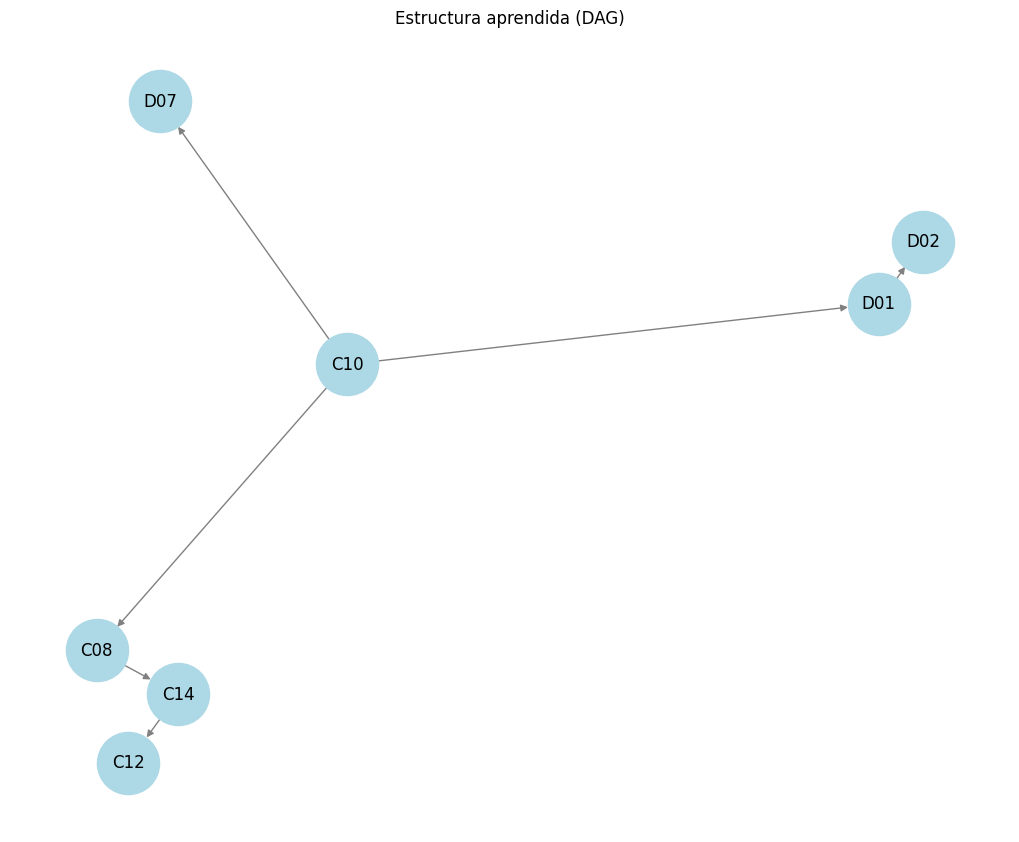

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C04': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D07': 'N', 'D09': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}



Nodos en la red bayesiana antes del fit:
['C08', 'C14', 'C10', 'D07', 'D01', 'C12', 'D02']

Nodos en la red bayesiana después del fit:
['C08', 'C14', 'C10', 'D07', 'D01', 'C12', 'D02']
Nodos del modelo: ['C04', 'C07', 'C08', 'C09', 'C10', 'C12', 'C13', 'C14', 'D01', 'D02', 'D03', 'D04', 'D07', 'D09', 'D10', 'H01', 'M01', 'SM1', 'SM3', 'SM4', 'Activity']
21
📌 Variables con un único valor en todo el DataFrame:
 - C04: 0
 - C07: 0
 - C09: 1
 - C13: 1
 - D03: 1
 - D04: 1
 - D10: 1
 - H01: 0
 - M01: 1
 - SM1: 1
 - SM3: 1
 - SM4: 1
12
Nodos de la red: ['C08', 'C14', 'C10', 'D07', 'D01', 'C12', 'D02']
7

CPD de la variable: C08
+--------+--------+--------------------+
| C10    | C10(0) | C10(1)             |
+--------+--------+--------------------+
| C08(0) | 1.0    | 0.1111111111111111 |
+--------+--------+--------------------+
| C08(1) | 0.0    | 0.8888888888888888 |
+--------+--------+--------------------+

CPD de la variable: C14
+--------+--------------------+--------+
| C08    | C08(0)

NetworkXError: The node Activity is not in the digraph.

In [ ]:
hc = HillClimbSearch(df_train)
model = hc.estimate(scoring_method="bic-d")

# Gráfica
import matplotlib.pyplot as plt
import networkx as nx
G = nx.DiGraph(model.edges())
plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=12)
plt.title("Estructura aprendida (DAG)")
plt.show()

# Aprender parámetros
bn = DiscreteBayesianNetwork(model.edges())

print("\nNodos en la red bayesiana antes del fit:")
print(bn.nodes())

bn.fit(df_train, estimator=MaximumLikelihoodEstimator)

print("\nNodos en la red bayesiana después del fit:")
print(bn.nodes())

print("Nodos del modelo:", model.nodes())
print(len(model.nodes()))

# Encuentra columnas con un único valor
cols_unico_valor = [col for col in df.columns if df[col].nunique() == 1]
# Mostrar resultados
print("📌 Variables con un único valor en todo el DataFrame:")
for col in cols_unico_valor:
    print(f" - {col}: {df[col].unique()[0]}")
print(len(cols_unico_valor))

print("Nodos de la red:", bn.nodes())
print(len(bn.nodes()))

# Mostrar CPTs
for cpd in bn.get_cpds():
    print(f"\nCPD de la variable: {cpd.variable}")
    print(cpd)

# Crear el objeto de inferencia
infer = VariableElimination(bn)
# Definir evidencia: valores discretizados de sensores
evidence = {
    "D03": 1,
    "D02": 1,
    "D07": 0
}

evidence_clean = {}
for var in evidence:
    if var not in bn.nodes():
        print(f"⚠️ Variable '{var}' no está en la red. No se puede usar como evidencia.")
    else:
        evidence_clean[var] = evidence[var]

# Mostrar la evidencia válida que se usará
print(f"✅ Evidencia utilizada para la inferencia: {evidence_clean}")

# Realizar la inferencia
query_result = infer.query(variables=["Activity"], evidence=evidence_clean)

# Mostrar resultados
print("Distribución de probabilidad para la actividad dada la evidencia:")
print(query_result)

**CONCLUSIÓN**: Aparece un error que indica que la variable *Activity* NO está en la red por lo que no se puede utilizar como variable de observación. Esto puede suceder porque el algoritmo *Hill Climbing* no ha detectado que haya relaciones suficientemente fuertes entre *Activity* y el resto de variables como para justificar una conexión. Puede deberse a haber usado datos comprimidos que pueden estar eliminando los patrones temporales que permiten inferir la actividad. Además, el criterio *BIC-d* penaliza las conexiones innecesarias por lo que si *Activity* no mejora el score o incluso lo empeora, se omite. 

En una red bayesiana, si un nodo está aislado, el modelo lo trata como independiente del resto por lo que:

* P(Activity | sensores) = P(Activity) → simplemente su distribución marginal.

* P(sensores | Activity) tampoco cambia: los sensores no dependen de Activity.

Vamos a probar usando otros métodos de puntuación a ver si incluyen la variable *Activity*. 

## K2

**K2** es un algoritmo *greedy* (codicioso) que requiere un orden fijo de las variables. 

Parte de un orden predefinido de las variables y añade padres anteriores en el orden, solo si mejora la función de puntuación. Por ello, no considera variables que vienen después en el orden como posibles padres. 

El algoritmo **K2** utiliza normalmente una función basada en la probabilidad a posteriori de la estructura o un puntuaje como el BDeu score (*Bayesian Dirichlet equivalence uniform*).

Sus desventajas son que depende totalmente del orden que le des a las variables y no explora todas las posibles estructuras, solo las que son compatibles con ese orden.

\* Que un algoritmo sea *greedy* quiere decir que toma decisiones locales y rápidas, eligiendo la mejor opción en cada paso sin revisar todas las posibles combinaciones futuras. No vuelve atrás para corregir decisiones anteriores.  

**EJEMPLO SENCILLO:**

Supongamos que tienes 3 variables: A, B, C, y un orden fijo: [A, B, C].

Empieza con A: no puede añadir padres (no hay variables antes de A).

Luego B: intenta añadir A como padre.

Calcula la puntuación si B no tiene padres.

Calcula la puntuación si B tiene a A como padre.

Si la puntuación mejora con A como padre, lo añade.

Finalmente C: intenta añadir A y/o B como padres, siempre verificando si la puntuación mejora cada vez que añade un padre.

Así, va construyendo la red agregando padres solo si mejora la puntuación.

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C04': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D07': 'N', 'D09': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C04': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D07': 'N', 'D09': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C04': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D07': 'N', 'D09': 'N', 

  0%|          | 0/1000000 [00:00<?, ?it/s]

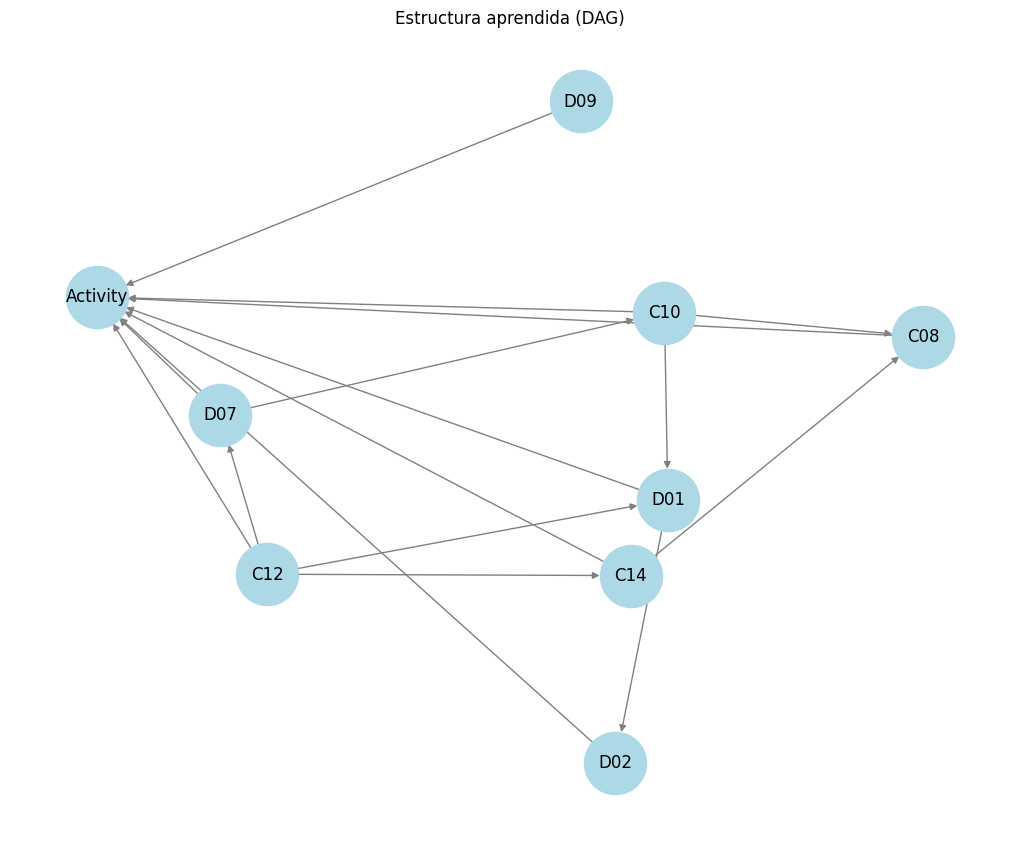

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C04': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D07': 'N', 'D09': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}



Nodos en la red bayesiana antes del fit:
['C08', 'Activity', 'C10', 'D01', 'C12', 'D07', 'C14', 'D02', 'D09']

Nodos en la red bayesiana después del fit:
['C08', 'Activity', 'C10', 'D01', 'C12', 'D07', 'C14', 'D02', 'D09']
Nodos del modelo: ['C04', 'C07', 'C08', 'C09', 'C10', 'C12', 'C13', 'C14', 'D01', 'D02', 'D03', 'D04', 'D07', 'D09', 'D10', 'H01', 'M01', 'SM1', 'SM3', 'SM4', 'Activity']
21
📌 Variables con un único valor en todo el DataFrame:
 - C04: 0
 - C07: 0
 - C09: 1
 - C13: 1
 - D03: 1
 - D04: 1
 - D10: 1
 - H01: 0
 - M01: 1
 - SM1: 1
 - SM3: 1
 - SM4: 1
12
Nodos de la red: ['C08', 'Activity', 'C10', 'D01', 'C12', 'D07', 'C14', 'D02', 'D09']
9

CPD de la variable: C08
+--------+--------+--------+--------+----------------------+
| C10    | C10(0) | C10(0) | C10(1) | C10(1)               |
+--------+--------+--------+--------+----------------------+
| C14    | C14(0) | C14(1) | C14(0) | C14(1)               |
+--------+--------+--------+--------+----------------------+
| C08(0)

In [ ]:
from pgmpy.estimators import HillClimbSearch

hc = HillClimbSearch(df_train)

# Usa K2 si lo tienes disponible
model = hc.estimate(scoring_method="k2")

# Gráfica
import matplotlib.pyplot as plt
import networkx as nx
G = nx.DiGraph(model.edges())
plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=12)
plt.title("Estructura aprendida (DAG)")
plt.show()

# Aprender parámetros
bn = DiscreteBayesianNetwork(model.edges())

print("\nNodos en la red bayesiana antes del fit:")
print(bn.nodes())

bn.fit(df_train, estimator=MaximumLikelihoodEstimator)

print("\nNodos en la red bayesiana después del fit:")
print(bn.nodes())

print("Nodos del modelo:", model.nodes())
print(len(model.nodes()))

# Encuentra columnas con un único valor
cols_unico_valor = [col for col in df.columns if df[col].nunique() == 1]
# Mostrar resultados
print("📌 Variables con un único valor en todo el DataFrame:")
for col in cols_unico_valor:
    print(f" - {col}: {df[col].unique()[0]}")
print(len(cols_unico_valor))

print("Nodos de la red:", bn.nodes())
print(len(bn.nodes()))

# Mostrar CPTs
for cpd in bn.get_cpds():
    print(f"\nCPD de la variable: {cpd.variable}")
    print(cpd)

# Crear el objeto de inferencia
infer = VariableElimination(bn)
# Definir evidencia: valores discretizados de sensores
evidence = {
    "D03": 1,
    "D02": 1,
    "D07": 0
}

evidence_clean = {}
for var in evidence:
    if var not in bn.nodes():
        print(f"⚠️ Variable '{var}' no está en la red. No se puede usar como evidencia.")
    else:
        evidence_clean[var] = evidence[var]

# Mostrar la evidencia válida que se usará
print(f"✅ Evidencia utilizada para la inferencia: {evidence_clean}")

# Realizar la inferencia
query_result = infer.query(variables=["Activity"], evidence=evidence_clean)

# Mostrar resultados
print("Distribución de probabilidad para la actividad dada la evidencia:")
print(query_result)


In [ ]:
model_vars = list(bn.nodes())  # Variables que el modelo sí conoce
model_vars.remove('Activity')  # Queremos predecir esta

correct = 0
for _, row in df_val.iterrows():
    # Filtrar solo columnas que están en el modelo
    evidence = row[model_vars].to_dict()
    prediction = infer.map_query(['Activity'], evidence=evidence)
    if prediction['Activity'] == row['Activity']:
        correct += 1

accuracy = correct / len(df_val)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
print(f"Accuracy en validación: {accuracy:.2%}")

Accuracy en validación: 30.00%


## TreeSearch

Este algoritmo construye un árbol de dependencia máxima o árbol de probabilidad conjunta usando información mutua entre pares de variables. 

Calcula la información mutua entre todas las variables y crea un árbol de máximo peso donde cada nodo solo tiene un padre, excepto el nodo raiz. A partir de este árbol, construye una red bayesiana simple pero efectiva. 

El problema que presenta este algoritmo es que solo aprende estructuras de árbol, es decir, una conexión por nodo y no puede capturar dependencias más complejas como ciclos o múltiples padres.

**EJEMPLO SENCILLO:**

Supón que tienes variables A, B, C y calculas su información mutua:

Par	    Info Mutua
A - B	0.8
B - C	0.3
A - C	0.5

El algoritmo construye un árbol que maximiza la suma de la información mutua.

Primero conecta A y B (máxima IM: 0.8).

Luego conecta A y C (0.5) antes que B y C (0.3), porque es mejor tener un árbol con enlaces fuertes.

Así crea un árbol donde cada nodo tiene un solo padre (excepto el root).

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C04': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D07': 'N', 'D09': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}


Building tree:   0%|          | 0/210.0 [00:00<?, ?it/s]

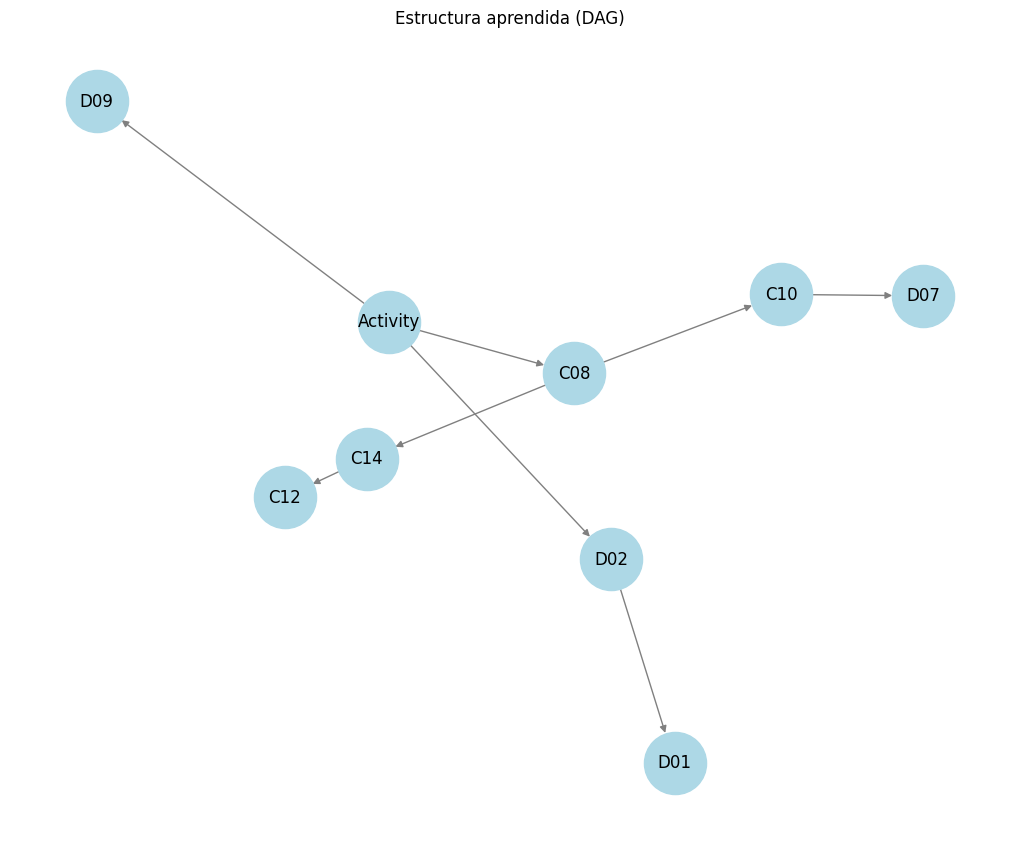

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C04': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D07': 'N', 'D09': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}



Nodos en la red bayesiana antes del fit:
['Activity', 'C08', 'D02', 'D09', 'C10', 'C14', 'D01', 'D07', 'C12']

Nodos en la red bayesiana después del fit:
['Activity', 'C08', 'D02', 'D09', 'C10', 'C14', 'D01', 'D07', 'C12']
Nodos del modelo: ['Activity', 'C08', 'D02', 'D09', 'C10', 'C14', 'D01', 'D07', 'C12']
9
📌 Variables con un único valor en todo el DataFrame:
 - C04: 0
 - C07: 0
 - C09: 1
 - C13: 1
 - D03: 1
 - D04: 1
 - D10: 1
 - H01: 0
 - M01: 1
 - SM1: 1
 - SM3: 1
 - SM4: 1
12
Nodos de la red: ['Activity', 'C08', 'D02', 'D09', 'C10', 'C14', 'D01', 'D07', 'C12']
9

CPD de la variable: Activity
+--------------+-----------+
| Activity(0)  | 0.243902  |
+--------------+-----------+
| Activity(2)  | 0.170732  |
+--------------+-----------+
| Activity(5)  | 0.0487805 |
+--------------+-----------+
| Activity(13) | 0.0243902 |
+--------------+-----------+
| Activity(16) | 0.0487805 |
+--------------+-----------+
| Activity(17) | 0.0487805 |
+--------------+-----------+
| Activity(18) |

In [ ]:
from pgmpy.estimators import TreeSearch

ts = TreeSearch(df_train, root_node="Activity")
model = ts.estimate() 

# Gráfica
import matplotlib.pyplot as plt
import networkx as nx
G = nx.DiGraph(model.edges())
plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=12)
plt.title("Estructura aprendida (DAG)")
plt.show()

# Aprender parámetros
bn = DiscreteBayesianNetwork(model.edges())

print("\nNodos en la red bayesiana antes del fit:")
print(bn.nodes())

bn.fit(df_train, estimator=MaximumLikelihoodEstimator)

print("\nNodos en la red bayesiana después del fit:")
print(bn.nodes())

print("Nodos del modelo:", model.nodes())
print(len(model.nodes()))

# Encuentra columnas con un único valor
cols_unico_valor = [col for col in df.columns if df[col].nunique() == 1]
# Mostrar resultados
print("📌 Variables con un único valor en todo el DataFrame:")
for col in cols_unico_valor:
    print(f" - {col}: {df[col].unique()[0]}")
print(len(cols_unico_valor))

print("Nodos de la red:", bn.nodes())
print(len(bn.nodes()))

# Mostrar CPTs
for cpd in bn.get_cpds():
    print(f"\nCPD de la variable: {cpd.variable}")
    print(cpd)

# Crear el objeto de inferencia
infer = VariableElimination(bn)
# Definir evidencia: valores discretizados de sensores
evidence = {
    "D03": 1,
    "D02": 1,
    "D07": 0
}

evidence_clean = {}
for var in evidence:
    if var not in bn.nodes():
        print(f"⚠️ Variable '{var}' no está en la red. No se puede usar como evidencia.")
    else:
        evidence_clean[var] = evidence[var]

# Mostrar la evidencia válida que se usará
print(f"✅ Evidencia utilizada para la inferencia: {evidence_clean}")

# Realizar la inferencia
query_result = infer.query(variables=["Activity"], evidence=evidence_clean)

# Mostrar resultados
print("Distribución de probabilidad para la actividad dada la evidencia:")
print(query_result)

In [ ]:
model_vars = list(bn.nodes())  # Variables que el modelo sí conoce
model_vars.remove('Activity')  # Queremos predecir esta

correct = 0
for _, row in df_val.iterrows():
    # Filtrar solo columnas que están en el modelo
    evidence = row[model_vars].to_dict()
    prediction = infer.map_query(['Activity'], evidence=evidence)
    if prediction['Activity'] == row['Activity']:
        correct += 1

accuracy = correct / len(df_val)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
print(f"Accuracy en validación: {accuracy:.2%}")

Accuracy en validación: 20.00%


# Datos 1 y Datos 2

Ahora, vamos a probar a generar el modelo con los datos completos y a entrenar la red con los datos comprimidos.

In [ ]:
letter = "A"
all_activities = []
all_sensors = []

for day in days:
    try:
        act_path = f"Data/Training2/{day}/{day}-{letter}/{day}-{letter}-activity.csv"
        sen_path = f"Data/Training2/{day}/{day}-{letter}/{day}-{letter}-sensors.csv"

        df_act = pd.read_csv(act_path, sep=";")
        df_sen = pd.read_csv(sen_path, sep=";")

        # Añadimos columna de día por si quieres rastrear luego
        df_act["DAY"] = day
        df_sen["DAY"] = day

        all_activities.append(df_act)
        all_sensors.append(df_sen)
    except FileNotFoundError:
        print(f"Archivos no encontrados para el día {day} - {letter}. Saltando.")
        continue

# Unimos todos los archivos en dos DataFrames completos
activities = pd.concat(all_activities, ignore_index=True)
sensors = pd.concat(all_sensors, ignore_index=True)

# Crea una lista con todas las horas de inicio (t1) y de fin (t2) del df activities 
t1 = [x.split(" ")[1] for x in activities["DATE BEGIN"].to_list()]
t2 = [x.split(" ")[1] for x in activities["DATE END"].to_list()]

# Crea una lista con SOLO las actividades
acts = activities["ACTIVITY"].to_list()
print(t1)
print(t2)
print(acts)

# Crea una lista con los tiempos del df sensors
timestamps = [x.split(" ")[1] for x in sensors["TIMESTAMP"].to_list()]
# Crea una lista con los sensores del df sensors
objects = sensors["OBJECT"].to_list()
# Crea una lista con los estados del df sensors
states = sensors["STATE"].to_list()

# Crea dic1 para los sensores y dic2 para actividades 
dic1,dic2 = {},{}
for s in set(objects):
    dic1[s] = []
for a in set(acts):
    dic2[a] = []
# A dic1 le asocia como claves los sensores y como valores una lista de tuplas (estado, hora)
for i in range(len(timestamps)):
    dic1[objects[i]].append((states[i],timestamps[i]))
# A dic2 le asocia como claves las actividades y como valores una lista de tuplas (inicio, fin)
for i in range(len(t1)):
    dic2[acts[i]].append((t1[i],t2[i]))

print(dic1) 
print(dic2)

tbegin,tend = min(timestamps[0],t1[0]),max(timestamps[-1],t2[-1])

data = {}
for t in enumerate_seconds(tbegin,tend):
    data[t] = [getActivity(dic2,t)]

for elem in dic1:
    events = dic1[elem]
    if len(events) > 1:
        for i in range(len(events) - 1):
            start_time = events[i][1]
            end_time = events[i + 1][1]
            for t in enumerate_seconds(start_time, end_time):
                if t in data:
                    data[t].append(elem)
print(data)

sorted_list_of_sensors = sorted(list(set(objects)))
print(sorted_list_of_sensors)

data_pd = []
for t in enumerate_seconds(tbegin,tend):
    # Crea una lista binaria + número de actividad
    data_pd.append(create_bit_vector(sorted_list_of_sensors,data[t][1:])+[create_act_number(data[t][0])])
    
print(data_pd)
df = pd.DataFrame(data_pd, columns=sorted_list_of_sensors+["Activity"])
print(df)

from sklearn.model_selection import train_test_split

# Suponemos que 'df_full' es tu conjunto con Activity
# random_state = 42 fija una semilla para la reproducibilidad
# stratify=df['Activity'] asegura que la proporción de clases se mantenga en los conjuntos de entrenamiento y prueba
df_trainval, df_test_simulado = train_test_split(df, test_size=0.15, random_state=42, stratify=df['Activity'])

# Dividimos ahora trainval en train y validación
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Activity'])

# Aprender la estructura de la red bayesiana
hc = HillClimbSearch(df_train)
model = hc.estimate(scoring_method="bic-d")

# Aprender parámetros
bn = DiscreteBayesianNetwork(model.edges())

['11:12:38.0', '11:15:51.0', '11:17:04.0', '11:18:36.0', '11:22:12.0', '11:25:55.0', '11:27:25.0', '11:29:24.0', '10:05:08.0', '10:08:41.0', '10:10:31.0', '10:15:04.0', '10:17:24.0', '10:19:28.0', '11:47:35.0', '11:51:18.0', '11:52:42.0', '11:56:56.0', '12:01:18.0', '12:03:58.0', '12:14:48.0', '12:16:38.0', '11:59:43.0', '12:01:23.0', '12:02:53.0', '12:05:49.0', '12:10:03.0', '12:11:25.0', '12:12:40.0', '12:14:09.0', '12:26:45.0', '12:29:03.0', '12:30:07.0', '12:31:29.0', '12:34:02.0', '12:39:08.0', '12:40:48.0', '12:43:02.0', '12:24:14.0', '12:25:34.0', '12:26:47.0', '12:27:46.0', '12:32:00.0', '12:36:29.0', '12:38:06.0', '12:40:07.0', '12:09:39.0', '12:11:17.0', '12:12:34.0', '12:14:03.0', '12:20:58.0', '12:27:24.0', '12:28:52.0', '12:31:09.0']
['11:15:25.0', '11:16:37.0', '11:18:06.0', '11:21:54.0', '11:24:59.0', '11:27:06.0', '11:29:01.0', '11:30:09.0', '10:08:07.0', '10:10:10.0', '10:14:47.0', '10:17:02.0', '10:18:55.0', '10:20:10.0', '11:50:57.0', '11:52:14.0', '11:56:28.0', '12:

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D07': 'N', 'D09': 'N', 'D10': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D07': 'N', 'D09': 'N', 'D10': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D07': 'N', 'D09': 'N', 'D10': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}


{'11:08:55': ['Idle', 'SM4', 'SM4', 'C14', 'M01', 'D04', 'C09', 'D10', 'D03', 'SM3', 'SM1'], '11:08:56': ['Idle', 'SM4', 'SM4', 'C14', 'M01', 'D04', 'C09', 'D10', 'D03', 'SM3', 'SM1'], '11:08:57': ['Idle', 'SM4', 'SM4', 'C14', 'M01', 'D04', 'C09', 'D10', 'D03', 'SM3', 'SM1'], '11:08:58': ['Idle', 'SM4', 'SM4', 'C14', 'M01', 'D04', 'C09', 'D10', 'D03', 'SM3', 'SM1'], '11:08:59': ['Idle', 'SM4', 'SM4', 'C14', 'M01', 'D04', 'C09', 'D10', 'D03', 'SM3', 'SM1'], '11:09:00': ['Idle', 'SM4', 'SM4', 'C14', 'M01', 'D04', 'C09', 'D10', 'D03', 'SM3', 'SM1'], '11:09:01': ['Idle', 'SM4', 'SM4', 'C14', 'M01', 'D04', 'C09', 'D10', 'D03', 'SM3', 'SM1'], '11:09:02': ['Idle', 'SM4', 'SM4', 'C14', 'M01', 'D04', 'C09', 'D10', 'D03', 'SM3', 'SM1'], '11:09:03': ['Idle', 'SM4', 'SM4', 'C14', 'M01', 'D04', 'C09', 'D10', 'D03', 'SM3', 'SM1'], '11:09:04': ['Idle', 'SM4', 'SM4', 'C14', 'M01', 'D04', 'C09', 'D10', 'D03', 'SM3', 'SM1'], '11:09:05': ['Idle', 'SM4', 'SM4', 'C14', 'M01', 'D04', 'C09', 'D10', 'D03', 'S

  0%|          | 13/1000000 [00:00<13:52:49, 20.01it/s]


In [ ]:
# Elimina filas consecutivas duplicadas (mantiene la primera de cada bloque idéntico)
df_comprimido = df_train.loc[(df_train.shift() != df_train).any(axis=1)].reset_index(drop=True)

In [ ]:
bn.fit(df_comprimido, estimator=MaximumLikelihoodEstimator)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D07': 'N', 'D09': 'N', 'D10': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'Activity': 'N'}


In [ ]:
model_vars = list(bn.nodes())  # Variables que el modelo sí conoce
model_vars.remove('Activity')  # Queremos predecir esta

correct = 0
for _, row in df_val.iterrows():
    # Filtrar solo columnas que están en el modelo
    evidence = row[model_vars].to_dict()
    prediction = infer.map_query(['Activity'], evidence=evidence)
    if prediction['Activity'] == row['Activity']:
        correct += 1

accuracy = correct / len(df_val)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
print(f"Accuracy en validación: {accuracy:.2%}")

Accuracy en validación: 32.81%


In [ ]:
print("Nodos del modelo:", model.nodes())
print(len(model.nodes()))

print("Nodos de la red:", bn.nodes())
print(len(bn.nodes()))

Nodos del modelo: ['C04', 'C07', 'C08', 'C09', 'C10', 'C12', 'C13', 'C14', 'D01', 'D02', 'D03', 'D04', 'D07', 'D09', 'D10', 'H01', 'M01', 'SM1', 'SM3', 'SM4', 'Activity']
21
Nodos de la red: ['C08', 'C14', 'C10', 'D01', 'Activity', 'C12', 'D02', 'D07', 'D09']
9


In [ ]:
# Mostrar CPTs
for cpd in bn.get_cpds():
    print(f"\nCPD de la variable: {cpd.variable}")
    print(cpd)


CPD de la variable: C08
+----------+-------------+-----+--------------+--------------+
| Activity | Activity(0) | ... | Activity(24) | Activity(24) |
+----------+-------------+-----+--------------+--------------+
| C10      | C10(0)      | ... | C10(0)       | C10(1)       |
+----------+-------------+-----+--------------+--------------+
| C08(0)   | 1.0         | ... | 1.0          | 0.5          |
+----------+-------------+-----+--------------+--------------+
| C08(1)   | 0.0         | ... | 0.0          | 0.5          |
+----------+-------------+-----+--------------+--------------+

CPD de la variable: C14
+----------+-------------+-----+--------------+--------------+
| Activity | Activity(0) | ... | Activity(24) | Activity(24) |
+----------+-------------+-----+--------------+--------------+
| C08      | C08(0)      | ... | C08(0)       | C08(1)       |
+----------+-------------+-----+--------------+--------------+
| C14(0)   | 0.0         | ... | 0.25         | 0.0          |
+----

In [ ]:
# Crear el objeto de inferencia
infer = VariableElimination(bn)
# Definir evidencia: valores discretizados de sensores
evidence = {
    "D03": 1,
    "D02": 1,
    "D07": 0
}

evidence_clean = {}
for var in evidence:
    if var not in bn.nodes():
        print(f"⚠️ Variable '{var}' no está en la red. No se puede usar como evidencia.")
    else:
        evidence_clean[var] = evidence[var]

# Mostrar la evidencia válida que se usará
print(f"✅ Evidencia utilizada para la inferencia: {evidence_clean}")

# Realizar la inferencia
query_result = infer.query(variables=["Activity"], evidence=evidence_clean)

# Mostrar resultados
print("Distribución de probabilidad para la actividad dada la evidencia:")
print(query_result)

⚠️ Variable 'D03' no está en la red. No se puede usar como evidencia.
✅ Evidencia utilizada para la inferencia: {'D02': 1, 'D07': 0}
Distribución de probabilidad para la actividad dada la evidencia:
+--------------+-----------------+
| Activity     |   phi(Activity) |
+==============+=================+
| Activity(0)  |          0.0000 |
+--------------+-----------------+
| Activity(2)  |          0.4000 |
+--------------+-----------------+
| Activity(5)  |          0.0000 |
+--------------+-----------------+
| Activity(13) |          0.2000 |
+--------------+-----------------+
| Activity(16) |          0.0000 |
+--------------+-----------------+
| Activity(17) |          0.0000 |
+--------------+-----------------+
| Activity(18) |          0.0000 |
+--------------+-----------------+
| Activity(21) |          0.0000 |
+--------------+-----------------+
| Activity(22) |          0.4000 |
+--------------+-----------------+
| Activity(24) |          0.0000 |
+--------------+---------------